<h1>Process & the ML Agenda</h1>

Process info from Monmouth University 2020 national poll

- courtesy of your mom

In [6]:
import os 
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split

<h2>Rename Columns</h2>

In [7]:
nat_2020 = pd.read_csv("../data/national_march_2020/MUP213_NATL_archive.tab", sep = "\t")

In [10]:
# propensity = pd.read_csv("../data/output11.csv", index_col=0)
# propensity = propensity.drop(columns = ["Unnamed: 0.1"])
propensity= pd.read_csv("../data/new_prop_scores_h3.csv")


In [11]:
nat_2020.columns

Index(['RESPID', 'PHTYPE', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6A', 'Q6B', 'Q6C',
       'Q6D', 'Q6E', 'Q6F', 'Q7', 'Q8', 'Q9', 'Q9A.1', 'Q9A.2', 'Q9A.3',
       'Q10A', 'Q10B', 'Q10C', 'Q10D', 'Q10E', 'Q10F', 'Q10G', 'QD1', 'Q11',
       'Q12', 'Q12B', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'QD2',
       'QD2A', 'QD3', 'QD4', 'QD5', 'QD5A', 'QD6', 'QD7', 'QD8', 'QD9', 'QD10',
       'QD11', 'FINALWGT'],
      dtype='object')

In [12]:
nat_2020 = nat_2020.rename(columns = {
        'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q11': 'likely_to_vote', 
        'Q12': 'vote_choice', 
        'Q12B': 'vote_choice_undecided', 
        'Q13': 'approve_trump',
        'Q14': 'approve_biden',
        'Q15': 'optimistic',
        'Q16': 'elec_enthusiasm',
        'Q17': 'economic_situation',
        'Q19': 'focused_imp_issues',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD4': 'education',
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender', 
        'QD11': 'state'
})

# Big Function to encode columns

In [13]:
def recodeCols(df):

    cols = df.columns
    # vote choice
    if '12_2' not in cols:
        # for march 2020 data
        df['vote_choice_recoded'] = df.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
        df['vote_choice_recoded'] = df['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))
    else:
        # for june 2020 data
        df['vote_choice'] = df.apply(lambda s: np.where(pd.isnull(s['12_1']), s['12_2'], s['12_1']), axis = 1)
      
        df['vote_choice_recoded'] = df.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
        df['vote_choice_recoded'] = df['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 4.0, 9.0], 3.0, s))
    # party recode
    df['party_recoded'] = df.apply(lambda s: np.where(s['party'] in [4.0, 9.0], s['party_unaffiliated'], s['party']), axis = 1)
    df['party_recoded'] = df['party_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))

    # age recode
    df['age_recoded'] = df.apply(lambda s: np.where(not pd.isnull(s['age_bin']), s['age_bin'], s['age']), axis = 1)

    df['age_recoded'] = df['age_recoded'].apply(lambda s: np.where(s >= 18 and s <= 34 and not pd.isnull(s), 1.0, np.where(s >= 35 and s <= 54, 2.0, 3.0)))   

    # approval ratings 
    df['approve_trump'] = df['approve_trump'] == 1
    df['approve_biden'] = df['approve_biden'] == 1 

    # race, overwrite if hispanic/latino
    df['latino'] = df['latino'] == 1

    def recode_race(s):
        if s['latino'] == 1 or s['race'] == 4: 
            return 4
        elif s['race'] != 5 and s['race'] != 9:
            return s['race']
        else:
            return 9
    df['race_recoded'] = df.apply(recode_race, axis = 1)

    # gender => male = True, female = False
    df['male'] = df['gender'] == 1

    # registered to vote

    df['registered_vote'] = df['registered_vote'] == 1


    # True if they think Trump is focused on important issues, False otherwise
    if 'focused_imp_issues' in cols:
        df['focused_imp_issues'] = df['focused_imp_issues'] == 1

    # combine some of the similar household concern categories 
    if 'top_household_concern' in cols:
        df['top_household_concern'] = df['top_household_concern'].apply(lambda s: np.where(s in [6.0, 7.0], 6.0, s))
        df['top_household_concern'] = df['top_household_concern'].apply(lambda s: np.where(s in [10.0, 11.0], 10.0, s))

    # turn into 1 = no college, 3 = college
    def recode_education(s):
        if s <= 3:
            return 1
        else:
            return 3
    df['education_recoded'] = df['education'].apply(recode_education)
    # combine into liberal, conservative, moderate, or other
    def recode_political_leaning(s):
        if s <= 2:
            return 1
        elif s == 4 or s == 9:
            return 2
        elif s == 3:
            return 3
        else:
            return 4
    df['political_leaning'] = df['political_leaning'].apply(recode_political_leaning)

    # Do you feel optimistic or pessimistic about the 2020 presidential election? 1 or 2 = optimistic of some sort, else pessimistic of some sort
    df['optimistic'] = df['optimistic'] <= 2

    # confidence in trump stamina to be president, under 2 is confident, over 2 is not confident
    if 'trump_stamina' in cols:
        df['trump_stamina'] = df['trump_stamina'] <= 2
    # confidence in biden stamina to be president, under 2 is confident, over 2 is not confident
    if 'biden_stamina' in cols:
        df['biden_stamina'] = df['biden_stamina'] <= 2
    ### https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
    def recode_region(s):
        new_england = [9.0, 23.0, 25.0, 33.0, 44.0, 50.0, 34.0, 36.0, 42.0]
        midwest = [18.0, 17.0, 26.0, 39.0, 55.0, 19.0, 20.0, 27.0, 29.0, 31.0, 38.0, 46.0]
        south = [10.0, 11.0, 12.0, 13.0, 24.0, 37.0, 45.0, 51.0, 54.0, 1.0, 21.0, 28.0, 47.0, 5.0, 22.0, 40.0, 48.0]
        west = [4.0, 8.0, 16.0, 35.0, 30.0, 49.0, 32.0, 56.0, 2.0, 6.0, 15.0, 41.0, 53.0]
        
        if s in new_england:
            return 1
        elif s in midwest:
            return 2 
        elif s in south:
            return 3
        elif s in west:
            return 4
        
    df['region'] = df['state'].apply(recode_region)

    # merge propensities
    df['age_recoded'] = df['age_recoded'].astype(int)
    df_result = pd.merge(df, propensity, 
                        on=['male', 'race_recoded', 'education_recoded', 'age_recoded', 'STATEFIP'], 
                        how='left')

    # Renaming the merged column for clarity
    df['propensity'] = df_result['mrp_subgroup_estimate']
    df = df.dropna(subset = ['vote_choice_recoded'], how = 'all')

    return df

In [14]:
nat_2020 = nat_2020.drop(columns = [c for c in nat_2020.columns if 'Q' in c])

In [15]:
nat_2020['vote_choice'].value_counts()

vote_choice
2.0    358
1.0    320
8.0     39
6.0     21
9.0     12
7.0      3
Name: count, dtype: int64

In [16]:
nat_2020.columns

Index(['RESPID', 'PHTYPE', 'top_household_concern', 'registered_vote',
       'likely_to_vote', 'vote_choice', 'vote_choice_undecided',
       'approve_trump', 'approve_biden', 'optimistic', 'elec_enthusiasm',
       'economic_situation', 'focused_imp_issues', 'party',
       'party_unaffiliated', 'political_leaning', 'education', 'age',
       'age_bin', 'latino', 'race', 'gender', 'state', 'FINALWGT'],
      dtype='object')

<h2>Recode Variables</h2>

<h3>Vote Choice</h3>

In [17]:
nat_2020['vote_choice_recoded'] = nat_2020.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
nat_2020['vote_choice_recoded'] = nat_2020['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))

<h3>Party Leaning</h3>

In [18]:
nat_2020['party_recoded'] = nat_2020.apply(lambda s: np.where(s['party'] in [4.0, 9.0], s['party_unaffiliated'], s['party']), axis = 1)
nat_2020['party_recoded'] = nat_2020['party_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))

<h3>Age</h3>

Convert so they're all in bins

In [19]:
nat_2020['age_recoded'] = nat_2020.apply(lambda s: np.where(not pd.isnull(s['age_bin']), s['age_bin'], s['age']), axis = 1)

nat_2020['age_recoded'] = nat_2020['age_recoded'].apply(lambda s: np.where(s >= 18 and s <= 34 and not pd.isnull(s), 1.0, 
                                                        np.where(s >= 35 and s <= 54, 2.0, 3.0)))

<h3>Approval Ratings</h3>

In [20]:
nat_2020['approve_trump'] = nat_2020['approve_trump'] == 1
nat_2020['approve_biden'] = nat_2020['approve_biden'] == 1

<h3>Race</h3>

Overwrite if hispanic/latino

In [21]:
nat_2020['latino'] = nat_2020['latino'] == 1

In [22]:
def recode_race(s):
    if s['latino'] == 1 or s['race'] == 4: 
        return 4
    elif s['race'] != 5 and s['race'] != 9:
        return s['race']
    else:
        return 9

In [23]:
nat_2020['race_recoded'] = nat_2020.apply(recode_race, axis = 1)

<h3>Gender</h3>

In [24]:
nat_2020['male'] = nat_2020['gender'] == 1

In [25]:
# nat_2020.to_csv("../data/nat_2020_cleaned_no_dummies.csv", index = False)

In [26]:
nat_2020['registered_vote'].value_counts()

registered_vote
1    754
2     94
9      3
Name: count, dtype: int64

In [27]:
nat_2020['focused_imp_issues'].value_counts()

focused_imp_issues
2    399
1    394
9     58
Name: count, dtype: int64

In [28]:
nat_2020['age_recoded'].value_counts()

age_recoded
3.0    357
2.0    304
1.0    190
Name: count, dtype: int64

In [29]:
nat_2020['economic_situation'].value_counts()

economic_situation
2    548
1    202
3     93
9      8
Name: count, dtype: int64

<h3>Registered to Vote</h3>

In [30]:
# True if they're registered to vote, false otherwise
nat_2020['registered_vote'] = nat_2020['registered_vote'] == 1

<h3>Focused on Important Issues</h3>

In [31]:
# True if they think Trump is focused on important issues, False otherwise
nat_2020['focused_imp_issues'] = nat_2020['focused_imp_issues'] == 1

In [32]:
nat_2020['focused_imp_issues'].value_counts()

focused_imp_issues
False    457
True     394
Name: count, dtype: int64

<h3>Combine Concerns</h3>

In [33]:
# combine some of the similar household concern categories 
nat_2020['top_household_concern'] = nat_2020['top_household_concern'].apply(lambda s: np.where(s in [6.0, 7.0], 6.0, s))
nat_2020['top_household_concern'] = nat_2020['top_household_concern'].apply(lambda s: np.where(s in [10.0, 11.0], 10.0, s))

<h3>Education</h3>

In [34]:
# turn into no high school, some college or vocational, college or others 
def recode_education(s):
    if s <= 3:
        return 1
    # elif s > 4 and s <=6:
    #     return 2
    else:
        return 3
    # else:
    #     return 9

In [35]:
nat_2020['education_recoded'] = nat_2020['education'].apply(recode_education)

<h3>Political Leaning</h3>

In [36]:
# combine into liberal, conservative, moderate, or other
def recode_political_leaning(s):
    if s <= 2:
        return 1
    elif s == 4 or s == 9:
        return 2
    elif s == 3:
        return 3
    else:
        return 4

In [37]:
nat_2020['political_leaning'] = nat_2020['political_leaning'].apply(recode_political_leaning)

<h3>Optimistic</h3>

In [38]:
# true if optimistic about website, false otherwise
nat_2020['optimistic'] = nat_2020['optimistic'] <= 2

<h3>Region</h3>

In [39]:
### https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
def recode_region(s):
    new_england = [9.0, 23.0, 25.0, 33.0, 44.0, 50.0, 34.0, 36.0, 42.0]
    midwest = [18.0, 17.0, 26.0, 39.0, 55.0, 19.0, 20.0, 27.0, 29.0, 31.0, 38.0, 46.0]
    south = [10.0, 11.0, 12.0, 13.0, 24.0, 37.0, 45.0, 51.0, 54.0, 1.0, 21.0, 28.0, 47.0, 5.0, 22.0, 40.0, 48.0]
    west = [4.0, 8.0, 16.0, 35.0, 30.0, 49.0, 32.0, 56.0, 2.0, 6.0, 15.0, 41.0, 53.0]
    
    if s in new_england:
        return 1
    elif s in midwest:
        return 2 
    elif s in south:
        return 3
    elif s in west:
        return 4
    
    

In [40]:
nat_2020['region'] = nat_2020['state'].apply(recode_region)

### merge propensity to this

In [41]:
# prop_avg_values = propensity.groupby(['male', 'race_recoded', 'education_recoded', 'age_recoded'])['mean'].max().reset_index()
# prop_avg_values
# make age recoded into int
nat_2020['age_recoded'] = nat_2020['age_recoded'].astype(int)
df_result = pd.merge(nat_2020, propensity, 
                     on=['male', 'race_recoded', 'education_recoded', 'age_recoded'], 
                     how='left')

# Renaming the merged column for clarity
nat_2020['propensity'] = df_result['mrp_subgroup_estimate']
nat_2020

,RESPID,PHTYPE,top_household_concern,registered_vote,likely_to_vote,vote_choice,vote_choice_undecided,approve_trump,approve_biden,optimistic,...,state,FINALWGT,vote_choice_recoded,party_recoded,age_recoded,race_recoded,male,education_recoded,region,propensity
0,11,2,20.0,True,1.0,9.0,9.0,False,False,True,...,24.0,0.879980,3.0,1.0,2,1,True,3,3.0,0.642936
1,14,2,29.0,True,1.0,1.0,NaN,True,False,True,...,34.0,1.089499,1.0,3.0,1,1,True,3,1.0,0.653866
2,19,2,28.0,True,1.0,1.0,NaN,True,False,True,...,37.0,0.520273,1.0,1.0,3,1,True,3,3.0,0.599719
3,30,2,20.0,True,1.0,2.0,NaN,False,True,True,...,37.0,0.573839,2.0,2.0,3,1,False,3,3.0,0.578647
4,43,2,20.0,True,1.0,8.0,1.0,False,True,False,...,13.0,0.972234,1.0,1.0,2,9,False,3,3.0,0.440859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,3746,1,10.0,True,1.0,2.0,NaN,False,False,False,...,26.0,0.469501,2.0,3.0,2,1,True,3,2.0,0.245812
847,3752,1,20.0,False,NaN,NaN,NaN,False,False,True,...,24.0,1.207679,NaN,2.0,1,1,False,3,3.0,0.246735
848,3754,2,30.0,True,1.0,8.0,3.0,True,True,True,...,12.0,0.906539,3.0,2.0,3,1,False,3,3.0,0.214182
849,3762,1,20.0,True,3.0,2.0,NaN,False,True,True,...,22.0,0.665262,2.0,2.0,2,2,False,3,3.0,0.309669


## Test Big function

In [42]:
nat_2020 = pd.read_csv("../data/national_march_2020/MUP213_NATL_archive.tab", sep = "\t")
nat_2020 = nat_2020.rename(columns = {
        'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q11': 'likely_to_vote', 
        'Q12': 'vote_choice', 
        'Q12B': 'vote_choice_undecided', 
        'Q13': 'approve_trump',
        'Q14': 'approve_biden',
        'Q15': 'optimistic',
        'Q16': 'elec_enthusiasm',
        'Q17': 'economic_situation',
        'Q19': 'focused_imp_issues',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD4': 'education',
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender', 
        'QD11': 'state'
})
nat_2020 = nat_2020.drop(columns = [c for c in nat_2020.columns if 'Q' in c])
nat_2020['STATEFIP'] = nat_2020['state']
nat_2020 = recodeCols(nat_2020)
# propensity2 = pd.read_csv('../data/output7.csv')
# # merge null propensities with propensities from output 7
# propensity2['prop_small'] = propensity2['mrp_subgroup_estimate']
# propensity2.drop(columns = ['mrp_subgroup_estimate'], inplace = True)
# nat_2020 = pd.merge(nat_2020, propensity2, 
#                         on=['male', 'race_recoded', 'education_recoded', 'age_recoded'], 
#                         how='left')
# # if nat2020 pre dummies has null propensity, then make it the propensity from output 7
# # fill null with prop_small
# nat_2020['propensity_fix'] = nat_2020['propensity'].fillna(nat_2020['prop_small'])
nat_2020
nat_2020_pre_dummies = nat_2020.copy()

In [43]:
nat_2020_pre_dummies

,RESPID,PHTYPE,top_household_concern,registered_vote,likely_to_vote,vote_choice,vote_choice_undecided,approve_trump,approve_biden,optimistic,...,FINALWGT,STATEFIP,vote_choice_recoded,party_recoded,age_recoded,race_recoded,male,education_recoded,region,propensity
0,11,2,20.0,True,1.0,9.0,9.0,False,False,True,...,0.879980,24.0,3.0,1.0,2,1,True,3,3.0,0.421949
1,14,2,29.0,True,1.0,1.0,NaN,True,False,True,...,1.089499,34.0,1.0,3.0,1,1,True,3,1.0,0.437077
2,19,2,28.0,True,1.0,1.0,NaN,True,False,True,...,0.520273,37.0,1.0,1.0,3,1,True,3,3.0,0.554456
3,30,2,20.0,True,1.0,2.0,NaN,False,True,True,...,0.573839,37.0,2.0,2.0,3,1,False,3,3.0,0.536192
4,43,2,20.0,True,1.0,8.0,1.0,False,True,False,...,0.972234,13.0,1.0,1.0,2,9,False,3,3.0,0.352004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,3742,2,20.0,True,1.0,1.0,NaN,False,False,True,...,0.469501,26.0,1.0,1.0,2,1,True,3,2.0,0.528974
846,3746,1,10.0,True,1.0,2.0,NaN,False,False,False,...,0.469501,26.0,2.0,3.0,2,1,True,3,2.0,0.528974
848,3754,2,30.0,True,1.0,8.0,3.0,True,True,True,...,0.906539,12.0,3.0,2.0,3,1,False,3,3.0,0.548515
849,3762,1,20.0,True,3.0,2.0,NaN,False,True,True,...,0.665262,22.0,2.0,2.0,2,2,False,3,3.0,0.160927


In [44]:
# nat_2020_pre_dummies['race_recoded'].value_counts()

In [45]:
nat_2020_june = pd.read_csv("../data/national_june_2020/MUP218_NATL_archive_full.tab", sep = "\t")

nat_2020_june.columns

Index(['RESPID', 'PHTYPE', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8A',
       'Q8B', 'Q8C', 'Q9', 'Q10', 'Q10A', 'Q10B', 'QD1', 'Q11', 'Q12_1',
       'Q12_2', 'Q12A', 'Q12B', 'Q13A', 'Q13B', 'Q14', 'Q14A', 'Q15', 'Q16',
       'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26',
       'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q35A',
       'Q35B', 'QD2', 'QD2A', 'QD2B', 'QD3', 'QD4', 'QD5', 'QD5A', 'QD6',
       'QD7', 'QD8', 'QD9', 'QD10', 'QD11', 'FINALWGT'],
      dtype='object')

In [46]:
nat_2020_june[['Q12_1',
       'Q12_2']]
#merge the two vote choice columns
nat_2020_june['vote_choice'] = nat_2020_june.apply(lambda s: np.where(pd.isnull(s['Q12_1']), s['Q12_2'], s['Q12_1']), axis = 1)
# drop row if 'Q12_1', 'Q12_2', 'Q12A', 'Q12B' all are null

nat_2020_june = nat_2020_june.dropna(subset = ['Q12_1', 'Q12_2', 'Q12A', 'Q12B'], how = 'all')

nat_2020_june['vote_choice_recoded'] = nat_2020_june.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
nat_2020_june['vote_choice_recoded'] = nat_2020_june['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 4.0, 9.0], 3.0, s))

KeyError: 'vote_choice_undecided'

In [ ]:
nat_2020_june['vote_choice_recoded'].value_counts()

KeyError: 'vote_choice_recoded'

In [47]:
nat_2020_june[['Q12_1',
       'Q12_2', 'Q12A', 'Q12B', 'vote_choice', 'vote_choice_recoded']]

KeyError: "['vote_choice_recoded'] not in index"

In [48]:
nat_2020_june = pd.read_csv("../data/national_june_2020/MUP218_NATL_archive_full.tab", sep = "\t")
nat_2020_june = nat_2020_june.rename(columns = {
        # 'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q11': 'likely_to_vote', 
        'Q12': 'vote_choice', 
        'Q12_1': '12_1',
        'Q12_2': '12_2',
        'Q12B': 'vote_choice_undecided', 
        'Q15': 'approve_trump',
        'Q16': 'approve_biden',
        'Q19': 'optimistic',
        'Q21': 'elec_enthusiasm',
        'Q3': 'economic_situation',
        # 'Q19': 'focused_imp_issues',
        'Q17': 'trump_stamina',
        'Q18': 'biden_stamina',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD4': 'education',
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender', 
        'QD11': 'state'
})
nat_2020_june = nat_2020_june.drop(columns = [c for c in nat_2020_june.columns if 'Q' in c])
nat_2020_june['STATEFIP'] = nat_2020_june['state']
nat_2020_june = recodeCols(nat_2020_june)
nat_2020_june.drop(columns=['12_1', '12_2', 'vote_choice', 'vote_choice_undecided'], inplace = True)
# propensity2 = pd.read_csv('../data/output7.csv')
# propensity2['prop_small'] = propensity2['mrp_subgroup_estimate']
# propensity2.drop(columns = ['mrp_subgroup_estimate'], inplace = True)
# nat_2020_june = pd.merge(nat_2020_june, propensity2, 
#                         on=['male', 'race_recoded', 'education_recoded', 'age_recoded'], 
#                         how='left')
# # if nat2020 pre dummies has null propensity, then make it the propensity from output 7
# # fill null with prop_small
# nat_2020_june['propensity_fix'] = nat_2020_june['propensity'].fillna(nat_2020_june['prop_small'])

In [49]:
nat_2020_june.columns

Index(['RESPID', 'PHTYPE', 'economic_situation', 'registered_vote',
       'likely_to_vote', 'approve_trump', 'approve_biden', 'trump_stamina',
       'biden_stamina', 'optimistic', 'elec_enthusiasm', 'party',
       'party_unaffiliated', 'political_leaning', 'education', 'age',
       'age_bin', 'latino', 'race', 'gender', 'state', 'FINALWGT', 'STATEFIP',
       'vote_choice_recoded', 'party_recoded', 'age_recoded', 'race_recoded',
       'male', 'education_recoded', 'region', 'propensity'],
      dtype='object')

In [50]:
nat_2020_aug = pd.read_csv("../data/national_aug_2020/MUP222_NATL_archive_full.tab", sep = "\t")
nat_2020_aug = nat_2020_aug.rename(columns = {
        'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q13': 'likely_to_vote', 
        'Q14': 'vote_choice', 
        # 'Q14_1': '14_1',
        # 'Q14_2': '14_2',
        'Q14B': 'vote_choice_undecided', 
        'Q17': 'approve_trump',
        'Q18': 'approve_biden',
        'Q21': 'optimistic',
        'Q23': 'elec_enthusiasm',
        # 'Q3': 'economic_situation',
        # 'Q19': 'focused_imp_issues',
        # 'Q17': 'trump_stamina',
        # 'Q18': 'biden_stamina',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD4': 'education',
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender', 
        'QD11': 'state'
})
nat_2020_aug = nat_2020_aug.drop(columns = [c for c in nat_2020_aug.columns if 'Q' in c])
# nat_2020_aug.columns
nat_2020_aug['STATEFIP'] = nat_2020_aug['state']

nat_2020_aug = recodeCols(nat_2020_aug)
nat_2020_aug.columns
nat_2020_aug.drop(columns=['vote_choice', 'vote_choice_undecided'], inplace = True)
# propensity2 = pd.read_csv('../data/output7.csv')
# propensity2['prop_small'] = propensity2['mrp_subgroup_estimate']
# propensity2.drop(columns = ['mrp_subgroup_estimate'], inplace = True)
# nat_2020_aug = pd.merge(nat_2020_aug, propensity2, 
#                         on=['male', 'race_recoded', 'education_recoded', 'age_recoded'], 
#                         how='left')
# # if nat2020 pre dummies has null propensity, then make it the propensity from output 7
# # fill null with prop_small
# nat_2020_aug['propensity_fix'] = nat_2020_aug['propensity'].fillna(nat_2020_aug['prop_small'])

In [51]:
# pull up column focused_imp_issues_2
nat_2020_aug = nat_2020_aug[nat_2020_aug['vote_choice_recoded'] != 3.0]
# change trump to be 1 and biden to be 0
# biden originally encoded as 2 and trump as 1. 
# drop if vote choice recorded is null
nat_2020_aug = nat_2020_aug.dropna(subset = ['vote_choice_recoded'])
# vote choice recoded to int
nat_2020_aug['vote_choice_recoded'] = nat_2020_aug['vote_choice_recoded'].astype(int)
nat_2020_aug['vote_choice_recoded'] = nat_2020_aug['vote_choice_recoded'].apply(lambda s: np.where(s == 1, 1, 0))

nat_2020_aug['vote_choice_recoded'].value_counts()
nat_2020_aug.to_csv("../data/nat_2020_aug_cleaned.csv", index = False)

<h2>Add Dummy Variables</h2>

In [52]:
# categoricals = ['top_household_concern', 'registered_vote', 'region',
#                 'likely_to_vote', 'vote_choice', 'vote_choice_undecided', 
#                 'elec_enthusiasm', 'political_leaning', 'race_recoded', 'party_recoded', 'age_recoded', 'economic_situation', 'education_recoded']

categoricals = ['top_household_concern', 'registered_vote', 'region','economic_situation','likely_to_vote', 'vote_choice', 'vote_choice_undecided', 'education_recoded','elec_enthusiasm', 'political_leaning', 'race_recoded', 'party_recoded', 'age_recoded']
june_categoricals = ['registered_vote', 'region','economic_situation','likely_to_vote',  'education_recoded','elec_enthusiasm', 'political_leaning','race_recoded', 'party_recoded', 'age_recoded']

In [53]:
def dummyGrabber(df, cats):
    for category in cats:
        df[category] = df[category].astype('category')
    dummies = pd.get_dummies(df[cats])
    df = df[[c for c in df.columns if c not in cats]]
        
    df = pd.concat([df, dummies], axis = 1)
    
    return df

In [54]:
for category in categoricals:
    nat_2020[category] = nat_2020[category].astype('category')


# dummies = pd.get_dummies(nat_2020[categoricals], drop_first=True)
dummies = pd.get_dummies(nat_2020[categoricals])

In [55]:
dummies


,top_household_concern_1.0,top_household_concern_2.0,top_household_concern_3.0,top_household_concern_4.0,top_household_concern_5.0,top_household_concern_6.0,top_household_concern_8.0,top_household_concern_9.0,top_household_concern_10.0,top_household_concern_12.0,...,race_recoded_2,race_recoded_3,race_recoded_4,race_recoded_9,party_recoded_1.0,party_recoded_2.0,party_recoded_3.0,age_recoded_1,age_recoded_2,age_recoded_3
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
846,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
848,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
849,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,True,False


In [56]:
nat_2020 = nat_2020[[c for c in nat_2020.columns if c not in categoricals]]


In [57]:
nat_2020_pre_dummies.columns

Index(['RESPID', 'PHTYPE', 'top_household_concern', 'registered_vote',
       'likely_to_vote', 'vote_choice', 'vote_choice_undecided',
       'approve_trump', 'approve_biden', 'optimistic', 'elec_enthusiasm',
       'economic_situation', 'focused_imp_issues', 'party',
       'party_unaffiliated', 'political_leaning', 'education', 'age',
       'age_bin', 'latino', 'race', 'gender', 'state', 'FINALWGT', 'STATEFIP',
       'vote_choice_recoded', 'party_recoded', 'age_recoded', 'race_recoded',
       'male', 'education_recoded', 'region', 'propensity'],
      dtype='object')

In [58]:
nat_2020 = pd.concat([nat_2020, dummies], axis = 1)

In [59]:
nat_2020 = nat_2020[(nat_2020['vote_choice_recoded'] != 3.0) | 
                    (nat_2020['vote_choice_recoded'] != 7.0) |
                    (pd.isnull(nat_2020['vote_choice_recoded']) == False)]






In [60]:
nat_2020.columns

Index(['RESPID', 'PHTYPE', 'approve_trump', 'approve_biden', 'optimistic',
       'focused_imp_issues', 'party', 'party_unaffiliated', 'education', 'age',
       'age_bin', 'latino', 'race', 'gender', 'state', 'FINALWGT', 'STATEFIP',
       'vote_choice_recoded', 'male', 'propensity',
       'top_household_concern_1.0', 'top_household_concern_2.0',
       'top_household_concern_3.0', 'top_household_concern_4.0',
       'top_household_concern_5.0', 'top_household_concern_6.0',
       'top_household_concern_8.0', 'top_household_concern_9.0',
       'top_household_concern_10.0', 'top_household_concern_12.0',
       'top_household_concern_13.0', 'top_household_concern_14.0',
       'top_household_concern_15.0', 'top_household_concern_16.0',
       'top_household_concern_17.0', 'top_household_concern_19.0',
       'top_household_concern_20.0', 'top_household_concern_28.0',
       'top_household_concern_29.0', 'top_household_concern_30.0',
       'registered_vote_True', 'region_1.0', 'region

<h2>Train Test Split</h2>

In [61]:
nat_2020['vote_choice_recoded']
# 1 is trump, 2 is biden, 3 is other/undecided/none
nat_2020['vote_choice_recoded'].value_counts()

vote_choice_recoded
2.0    381
1.0    334
3.0     38
Name: count, dtype: int64

In [62]:
nat_2020.columns

Index(['RESPID', 'PHTYPE', 'approve_trump', 'approve_biden', 'optimistic',
       'focused_imp_issues', 'party', 'party_unaffiliated', 'education', 'age',
       'age_bin', 'latino', 'race', 'gender', 'state', 'FINALWGT', 'STATEFIP',
       'vote_choice_recoded', 'male', 'propensity',
       'top_household_concern_1.0', 'top_household_concern_2.0',
       'top_household_concern_3.0', 'top_household_concern_4.0',
       'top_household_concern_5.0', 'top_household_concern_6.0',
       'top_household_concern_8.0', 'top_household_concern_9.0',
       'top_household_concern_10.0', 'top_household_concern_12.0',
       'top_household_concern_13.0', 'top_household_concern_14.0',
       'top_household_concern_15.0', 'top_household_concern_16.0',
       'top_household_concern_17.0', 'top_household_concern_19.0',
       'top_household_concern_20.0', 'top_household_concern_28.0',
       'top_household_concern_29.0', 'top_household_concern_30.0',
       'registered_vote_True', 'region_1.0', 'region

In [63]:
june_dummies = dummyGrabber(nat_2020_june, june_categoricals)

In [64]:
# june_dummies.columns
nat_2020_june_clean = june_dummies.drop(columns = ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education',])
nat_2020_june_clean

,approve_trump,approve_biden,trump_stamina,biden_stamina,optimistic,state,FINALWGT,STATEFIP,vote_choice_recoded,male,...,race_recoded_2,race_recoded_3,race_recoded_4,race_recoded_9,party_recoded_1.0,party_recoded_2.0,party_recoded_3.0,age_recoded_1,age_recoded_2,age_recoded_3
0,False,True,False,True,False,37,0.649035,37,2.0,False,...,True,False,False,False,False,True,False,False,False,True
1,False,False,False,True,True,36,0.585878,36,2.0,True,...,False,False,False,False,False,True,False,False,False,True
2,False,True,False,True,True,13,0.943746,13,2.0,False,...,True,False,False,False,False,True,False,False,True,False
5,False,False,False,True,False,42,1.355759,42,2.0,False,...,False,False,False,False,False,True,False,False,True,False
6,False,False,False,True,True,9,0.524317,9,2.0,True,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,False,False,True,False,True,34,1.084173,34,1.0,True,...,False,False,False,False,False,False,True,False,False,True
863,True,False,True,False,True,53,2.519819,53,1.0,True,...,False,True,False,False,True,False,False,False,True,False
864,True,False,True,False,True,6,0.864748,6,1.0,False,...,False,False,False,False,True,False,False,False,True,False
865,False,False,False,True,True,6,1.029771,6,2.0,False,...,False,False,False,False,False,True,False,False,False,True


In [65]:
nat_2020_june

,RESPID,PHTYPE,economic_situation,registered_vote,likely_to_vote,approve_trump,approve_biden,trump_stamina,biden_stamina,optimistic,...,FINALWGT,STATEFIP,vote_choice_recoded,party_recoded,age_recoded,race_recoded,male,education_recoded,region,propensity
0,4,2,1,True,1.0,False,True,False,True,False,...,0.649035,37,2.0,2.0,3,2,False,3,3,0.141001
1,5,2,2,True,1.0,False,False,False,True,True,...,0.585878,36,2.0,2.0,3,1,True,3,1,0.430757
2,17,2,2,True,1.0,False,True,False,True,True,...,0.943746,13,2.0,2.0,2,2,False,3,3,0.153939
5,21,2,1,True,1.0,False,False,False,True,False,...,1.355759,42,2.0,2.0,2,1,False,1,1,0.604932
6,22,2,1,True,2.0,False,False,False,True,True,...,0.524317,9,2.0,1.0,2,1,True,3,1,0.453944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,20778,2,2,True,3.0,False,False,True,False,True,...,1.084173,34,1.0,3.0,3,1,True,1,1,0.554107
863,20786,1,2,True,1.0,True,False,True,False,True,...,2.519819,53,1.0,1.0,2,3,True,3,4,0.255262
864,20787,1,2,True,1.0,True,False,True,False,True,...,0.864748,6,1.0,1.0,2,1,False,3,4,0.422741
865,20789,1,2,True,1.0,False,False,False,True,True,...,1.029771,6,2.0,2.0,3,1,False,3,4,0.418810


## drop columns that made voter choice recoded column

In [66]:
nat_2020_clean = nat_2020.drop(columns=[
       'vote_choice_1.0','vote_choice_2.0', 'vote_choice_6.0',
       'vote_choice_7.0', 'vote_choice_8.0', 'vote_choice_9.0', 'vote_choice_undecided_1.0',
       'vote_choice_undecided_2.0', 'vote_choice_undecided_3.0',
       'vote_choice_undecided_9.0',
       'RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education', 'state'])

nat_2020_clean.columns

# keep or or drop FINALWGT?
# use state? income? education? -> not in data rn, keep in mind for future


# nat_2020_clean.to_csv('yeet.csv', index = False)

Index(['approve_trump', 'approve_biden', 'optimistic', 'focused_imp_issues',
       'FINALWGT', 'STATEFIP', 'vote_choice_recoded', 'male', 'propensity',
       'top_household_concern_1.0', 'top_household_concern_2.0',
       'top_household_concern_3.0', 'top_household_concern_4.0',
       'top_household_concern_5.0', 'top_household_concern_6.0',
       'top_household_concern_8.0', 'top_household_concern_9.0',
       'top_household_concern_10.0', 'top_household_concern_12.0',
       'top_household_concern_13.0', 'top_household_concern_14.0',
       'top_household_concern_15.0', 'top_household_concern_16.0',
       'top_household_concern_17.0', 'top_household_concern_19.0',
       'top_household_concern_20.0', 'top_household_concern_28.0',
       'top_household_concern_29.0', 'top_household_concern_30.0',
       'registered_vote_True', 'region_1.0', 'region_2.0', 'region_3.0',
       'region_4.0', 'economic_situation_1', 'economic_situation_2',
       'economic_situation_3', 'economic_si

In [67]:
# pull up column focused_imp_issues_2
nat_2020_june = nat_2020_june[nat_2020_june['vote_choice_recoded'] != 3.0]
# change trump to be 1 and biden to be 0
# biden originally encoded as 2 and trump as 1. 
# drop if vote choice recorded is null
nat_2020_june = nat_2020_june.dropna(subset = ['vote_choice_recoded'])
# vote choice recoded to int
nat_2020_june['vote_choice_recoded'] = nat_2020_june['vote_choice_recoded'].astype(int)
nat_2020_june['vote_choice_recoded'] = nat_2020_june['vote_choice_recoded'].apply(lambda s: np.where(s == 1, 1, 0))

nat_2020_june['vote_choice_recoded'].value_counts()

vote_choice_recoded
0    405
1    289
Name: count, dtype: int64

In [68]:
nat_2020_june.columns

Index(['RESPID', 'PHTYPE', 'economic_situation', 'registered_vote',
       'likely_to_vote', 'approve_trump', 'approve_biden', 'trump_stamina',
       'biden_stamina', 'optimistic', 'elec_enthusiasm', 'party',
       'party_unaffiliated', 'political_leaning', 'education', 'age',
       'age_bin', 'latino', 'race', 'gender', 'state', 'FINALWGT', 'STATEFIP',
       'vote_choice_recoded', 'party_recoded', 'age_recoded', 'race_recoded',
       'male', 'education_recoded', 'region', 'propensity'],
      dtype='object')

In [69]:
def checkVoteRecode(df):
    df = df[df['vote_choice_recoded'] != 3.0]
    # change trump to be 1 and biden to be 0
    # biden originally encoded as 2 and trump as 1. 
    # drop if vote choice recorded is null
    df = df.dropna(subset = ['vote_choice_recoded'])
    # vote choice recoded to int
    df['vote_choice_recoded'] = df['vote_choice_recoded'].astype(int)
    df['vote_choice_recoded'] = df['vote_choice_recoded'].apply(lambda s: np.where(s == 1, 1, 0))


    return df

In [70]:
nat_2020_june_m = nat_2020_june[['vote_choice_recoded', 'age_recoded', 'education_recoded', 'race_recoded', 'male', 'state']]
nat_2020_mar_m = nat_2020_pre_dummies[['vote_choice_recoded', 'age_recoded', 'education_recoded', 'race_recoded', 'male', 'state']]
nat_2020_aug_m = nat_2020_aug[['vote_choice_recoded', 'age_recoded', 'education_recoded', 'race_recoded', 'male', 'state']]
# pull up column focused_imp_issues_2
# nat_2020_mar_m = nat_2020_mar_m[nat_2020_mar_m['vote_choice_recoded'] != 3.0]
# # change trump to be 1 and biden to be 0
# # biden originally encoded as 2 and trump as 1. 
# # drop if vote choice recorded is null
# nat_2020_mar_m = nat_2020_mar_m.dropna(subset = ['vote_choice_recoded'])
# # vote choice recoded to int
# nat_2020_mar_m['vote_choice_recoded'] = nat_2020_mar_m['vote_choice_recoded'].astype(int)
# nat_2020_mar_m['vote_choice_recoded'] = nat_2020_mar_m['vote_choice_recoded'].apply(lambda s: np.where(s == 1, 1, 0))
nat_2020_june_m = checkVoteRecode(nat_2020_june_m)
nat_2020_aug_m = checkVoteRecode(nat_2020_aug_m)
nat_2020_mar_m = checkVoteRecode(nat_2020_mar_m)
nat_2020_mar_m['vote_choice_recoded'].value_counts()
combo_j_a_m = pd.concat([nat_2020_mar_m, nat_2020_june_m,nat_2020_aug_m]).reset_index(drop = True)
combo_j_a_m.dropna(subset = ['state'], inplace = True)
combo_j_a_m['state'] = combo_j_a_m['state'].astype(int)
# combo_j_a_m.to_csv('../data/nat_2020_aug_june_mar.csv', index = False)

In [71]:
# nat_2020_june.to_csv('../data/nat_2020_june_cleaned.csv', index = False)

In [72]:
# get propensity scores, use those as a column in the data, then train on data + that then 
nat_2020.loc[776].to_dict()

{'RESPID': 3484,
 'PHTYPE': 1,
 'approve_trump': False,
 'approve_biden': False,
 'optimistic': False,
 'focused_imp_issues': False,
 'party': 2,
 'party_unaffiliated': nan,
 'education': 7,
 'age': 65,
 'age_bin': nan,
 'latino': False,
 'race': 2,
 'gender': 2,
 'state': 13.0,
 'FINALWGT': 0.772958285,
 'STATEFIP': 13.0,
 'vote_choice_recoded': 2.0,
 'male': False,
 'propensity': 0.151848022589886,
 'top_household_concern_1.0': False,
 'top_household_concern_2.0': True,
 'top_household_concern_3.0': False,
 'top_household_concern_4.0': False,
 'top_household_concern_5.0': False,
 'top_household_concern_6.0': False,
 'top_household_concern_8.0': False,
 'top_household_concern_9.0': False,
 'top_household_concern_10.0': False,
 'top_household_concern_12.0': False,
 'top_household_concern_13.0': False,
 'top_household_concern_14.0': False,
 'top_household_concern_15.0': False,
 'top_household_concern_16.0': False,
 'top_household_concern_17.0': False,
 'top_household_concern_19.0': Fals

In [73]:
nat_2020_clean['vote_choice_recoded'].value_counts()
# if vote choice recorded is 7, make the value 3
nat_2020_clean['vote_choice_recoded'] = nat_2020_clean['vote_choice_recoded'].apply(lambda s: np.where(s == 7, 3, s))
nat_2020_clean['vote_choice_recoded'].isna().sum()

0

In [74]:
# (nat_2020_clean['vote_choice_recoded'] == 3.0).sum() sum of 3.0 answers is 38
# drop vote choice 3.0
nat_2020_clean = nat_2020_clean[nat_2020_clean['vote_choice_recoded'] != 3.0]
# change trump to be 1 and biden to be 0
# biden originally encoded as 2 and trump as 1. 
# drop if vote choice recorded is null
nat_2020_clean = nat_2020_clean.dropna(subset = ['vote_choice_recoded'])
# vote choice recoded to int
nat_2020_clean['vote_choice_recoded'] = nat_2020_clean['vote_choice_recoded'].astype(int)
nat_2020_clean['vote_choice_recoded'] = nat_2020_clean['vote_choice_recoded'].apply(lambda s: np.where(s == 1, 1, 0))

In [75]:
nat_2020_june_clean = nat_2020_june_clean[nat_2020_june_clean['vote_choice_recoded'] != 3.0]
# change trump to be 1 and biden to be 0
# biden originally encoded as 2 and trump as 1. 
# drop if vote choice recorded is null
nat_2020_june_clean = nat_2020_june_clean.dropna(subset = ['vote_choice_recoded'])
# vote choice recoded to int
nat_2020_june_clean['vote_choice_recoded'] = nat_2020_june_clean['vote_choice_recoded'].astype(int)
nat_2020_june_clean['vote_choice_recoded'] = nat_2020_june_clean['vote_choice_recoded'].apply(lambda s: np.where(s == 1, 1, 0))

In [76]:
nat_2020_june_clean.to_csv('june_vote_choice.csv', index = False)

In [77]:
nat_2020_clean['vote_choice_recoded'].value_counts().sum()

715

In [78]:
nat_2020_clean2= nat_2020_clean.drop(columns=['FINALWGT',  ])
nat_2020_clean2.columns

Index(['approve_trump', 'approve_biden', 'optimistic', 'focused_imp_issues',
       'STATEFIP', 'vote_choice_recoded', 'male', 'propensity',
       'top_household_concern_1.0', 'top_household_concern_2.0',
       'top_household_concern_3.0', 'top_household_concern_4.0',
       'top_household_concern_5.0', 'top_household_concern_6.0',
       'top_household_concern_8.0', 'top_household_concern_9.0',
       'top_household_concern_10.0', 'top_household_concern_12.0',
       'top_household_concern_13.0', 'top_household_concern_14.0',
       'top_household_concern_15.0', 'top_household_concern_16.0',
       'top_household_concern_17.0', 'top_household_concern_19.0',
       'top_household_concern_20.0', 'top_household_concern_28.0',
       'top_household_concern_29.0', 'top_household_concern_30.0',
       'registered_vote_True', 'region_1.0', 'region_2.0', 'region_3.0',
       'region_4.0', 'economic_situation_1', 'economic_situation_2',
       'economic_situation_3', 'economic_situation_9', 

In [79]:
nat_2020_june_clean2 = nat_2020_june_clean.drop(columns=['FINALWGT', 'state'])

In [80]:
nat_2020_june_clean2

,approve_trump,approve_biden,trump_stamina,biden_stamina,optimistic,STATEFIP,vote_choice_recoded,male,propensity,registered_vote_True,...,race_recoded_2,race_recoded_3,race_recoded_4,race_recoded_9,party_recoded_1.0,party_recoded_2.0,party_recoded_3.0,age_recoded_1,age_recoded_2,age_recoded_3
0,False,True,False,True,False,37,0,False,0.141001,True,...,True,False,False,False,False,True,False,False,False,True
1,False,False,False,True,True,36,0,True,0.430757,True,...,False,False,False,False,False,True,False,False,False,True
2,False,True,False,True,True,13,0,False,0.153939,True,...,True,False,False,False,False,True,False,False,True,False
5,False,False,False,True,False,42,0,False,0.604932,True,...,False,False,False,False,False,True,False,False,True,False
6,False,False,False,True,True,9,0,True,0.453944,True,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,False,False,True,False,True,34,1,True,0.554107,True,...,False,False,False,False,False,False,True,False,False,True
863,True,False,True,False,True,53,1,True,0.255262,True,...,False,True,False,False,True,False,False,False,True,False
864,True,False,True,False,True,6,1,False,0.422741,True,...,False,False,False,False,True,False,False,False,True,False
865,False,False,False,True,True,6,0,False,0.418810,True,...,False,False,False,False,False,True,False,False,False,True


In [81]:
# nat_2020_clean2['focused_imp_issues']

In [82]:
# X = nat_2020_june_clean2.drop(columns = ['vote_choice_recoded'])
# y = nat_2020_june_clean2['vote_choice_recoded']
X = nat_2020_clean2.drop(columns = ['vote_choice_recoded'])
y = nat_2020_clean2['vote_choice_recoded']
# train test split
# TODO: consider stratifying by anything???? 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 13, stratify=X['male'])

In [83]:
y_test.value_counts()

vote_choice_recoded
0    185
1    173
Name: count, dtype: int64

In [84]:
y_train.value_counts()

vote_choice_recoded
0    196
1    161
Name: count, dtype: int64

In [85]:
import os
import numpy as np
import pandas as pd

from utils import * 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, auc, roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, accuracy_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np 
import os 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.datasets import load_iris, make_classification
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import XGBRegressor, XGBClassifier

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

In [86]:
models = [
  

    # ("Logistic Regression Classification", LogisticRegression(), {'C': [1, 2]}),
    # ("SVC", SVC(C = 10), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    # ("Decision Tree Regression", DecisionTreeClassifier(), {'max_depth':[0,2, 5]}),
    ("Random Forest Classification", RandomForestClassifier(), {'n_estimators': [100,150,200]}),
    ("Random Forest Classification2", RandomForestClassifier(min_samples_split = 3,  n_estimators=75), {'n_estimators': [100,150,200]}), 
    ("Gradient Boosting Classification", GradientBoostingClassifier(criterion='squared_error', n_estimators=440, max_depth=5, learning_rate=0.012, random_state=0, max_features='sqrt'), {'n_estimators': [100,150,200]}),
    ("Gradient Boosting Classification2", GradientBoostingClassifier(criterion='squared_error', n_estimators=100, max_depth=7, learning_rate=0.2, random_state=0, max_features='sqrt'), {'n_estimators': [100,150,200]}),
    ("Gradient Boosting Classification3", GradientBoostingClassifier( n_estimators=375, max_depth=3, learning_rate=0.02, random_state=0, max_features=2), {'n_estimators': [100,150,200]}),
]

In [101]:
best_f1 = 0
X = nat_2020_clean2.drop(columns = ['vote_choice_recoded', 'STATEFIP'])
y = nat_2020_clean2['vote_choice_recoded']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.45, random_state = 11)
# mar_pred = modelFunc(X_train, y_train, X_test, y_test, nat_2020_pre_dummies, models)
for model in models:

    name = model[0]
    print(model[0])
    clf = model[1]
    
    grids =  GridSearchCV(clf, param_grid={}, scoring='f1_weighted' ,cv=5)
    grids.fit(X_train, y_train)
    y_preds = grids.best_estimator_.predict(X_test)
    if f1_score(y_test, y_preds, average='weighted') >= best_f1:
        new_model = grids.best_estimator_
    #print('train result', result['test_score'])
    grids.best_score_
    # print('mean_score:', -np.mean(result['test_score']))
    # y_preds = grids.best_estimator_.predict(X_test)

    print(f1_score(y_test, y_preds, average='weighted'))
new_model.fit(X_train, y_train)
y_preds = new_model.predict_proba(X_test)
y_preds = [x[1] for x in y_preds]
X_test_copy = X_test.copy()
X_test_copy['predicted_vote'] = y_preds
X_test_copy['actual_vote'] = y_test
X_test_copy_filtered = X_test_copy[['approve_trump', 'approve_biden', 'optimistic','male',  'race_recoded_1', 'race_recoded_2', 'race_recoded_3', 'race_recoded_4',
    'race_recoded_9', 'party_recoded_1.0',
    'party_recoded_2.0', 'age_recoded_1', 'age_recoded_2', 'age_recoded_3', 'predicted_vote','actual_vote', 'education_recoded_3', 'education_recoded_1']]

filtered_nat_df = nat_2020_pre_dummies.loc[X_test_copy_filtered.index].drop(columns= ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education', 'vote_choice_recoded', 'state'])
filtered_nat_df['predicted_vote'] = X_test_copy['predicted_vote']
filtered_nat_df['actual_vote'] = X_test_copy['actual_vote']
df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'] )['predicted_vote'].mean()
roc_auc_score(y_test, y_preds)
df_final_pred

Random Forest Classification
0.9469755345396421
Random Forest Classification2
0.9406297386251335
Gradient Boosting Classification
0.9251594256891468
Gradient Boosting Classification2
0.9189558481751994
Gradient Boosting Classification3
0.9281798372013897


education_recoded                      1         3
age_recoded race_recoded male                     
1           1            False  0.251069  0.381188
                         True   0.393195  0.355886
            2            False  0.000000  0.030788
                         True   0.000000  0.050556
            3            False  0.000000  0.059599
                         True   0.000000  0.018179
            4            False  0.166491  0.377299
                         True   0.715480  0.380615
            9            False  0.024549  0.000000
                         True   0.000000  0.444755
2           1            False  0.800108  0.531345
                         True   0.798599  0.552718
            2            False  0.100795  0.035417
                         True   0.206999  0.054593
            3            True   0.000000  0.138124
            4            False  0.000000  0.509474
                         True   0.698722  0.315398
            9            False  0.000000  0.213659
                         True   0.953518  0.551146
3           1            False  0.579301  0.560383
                         True   0.752817  0.625736
            2            False  0.025343  0.030890
                         True   0.029464  0.145430
            3            False  0.000000  0.045825
            4            False  0.000000  0.478204
                         True   0.408485  0.380069
            9            False  0.044027  0.162726

In [105]:
df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'] )['predicted_vote'].mean()
all_genders = [True, False ]
all_ages = [1,2, 3]
all_educations = [1,3]
all_races = [1,2, 3,4,9]
all_combinations = pd.MultiIndex.from_product([all_ages,all_races, all_genders, all_educations], names=['age_recoded','race_recoded', 'male','education_recoded']).to_frame(index=False)
mar_pred = pd.merge(all_combinations,df_final_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')

In [106]:
mar_pred

,age_recoded,race_recoded,male,education_recoded,predicted_vote
0,1,1,False,1,0.251069
1,1,1,False,3,0.381188
2,1,1,True,1,0.393195
3,1,1,True,3,0.355886
4,1,2,False,1,NaN
5,1,2,False,3,0.030788
6,1,2,True,1,NaN
7,1,2,True,3,0.050556
8,1,3,False,1,NaN
9,1,3,False,3,0.059599


In [102]:
filtered_nat_df

,top_household_concern,registered_vote,likely_to_vote,vote_choice,vote_choice_undecided,approve_trump,approve_biden,optimistic,elec_enthusiasm,economic_situation,...,STATEFIP,party_recoded,age_recoded,race_recoded,male,education_recoded,region,propensity,predicted_vote,actual_vote
740,13.0,True,1.0,2.0,NaN,False,False,True,3,2,...,35.0,2.0,2,4,True,3,4.0,0.246735,0.120524,0
341,20.0,True,1.0,1.0,NaN,True,False,True,1,2,...,48.0,1.0,2,9,True,3,3.0,0.357377,0.938380,1
604,20.0,True,1.0,1.0,NaN,False,False,True,1,2,...,48.0,1.0,3,1,True,3,3.0,0.563673,0.853069,1
554,13.0,True,1.0,1.0,NaN,False,False,False,1,2,...,34.0,3.0,2,4,False,3,1.0,0.232390,0.358314,1
779,1.0,True,1.0,2.0,NaN,False,False,True,1,2,...,31.0,3.0,3,1,True,3,2.0,0.624314,0.211810,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,1.0,True,1.0,2.0,NaN,False,False,False,3,1,...,6.0,2.0,2,1,True,3,4.0,0.440859,0.111395,0
619,12.0,True,1.0,2.0,NaN,False,False,False,2,1,...,31.0,3.0,2,1,False,3,2.0,0.610809,0.264304,0
618,13.0,True,1.0,2.0,NaN,False,False,True,1,1,...,12.0,2.0,2,2,True,3,3.0,0.158535,0.068991,0
544,9.0,True,1.0,2.0,NaN,False,True,False,1,2,...,24.0,2.0,3,2,True,1,3.0,0.123128,0.024985,0


In [109]:
def modelFunc(X_train, y_train, X_test, y_test, data_dummies, models):
    best_f1 = 0
    for model in models:
    
        name = model[0]
        print(model[0])
        clf = model[1]
      
        grids =  GridSearchCV(clf, param_grid={}, scoring='f1_weighted' ,cv=5)
        grids.fit(X_train, y_train)
        y_preds = grids.best_estimator_.predict(X_test)
        if f1_score(y_test, y_preds, average='weighted') >= best_f1:
            new_model = grids.best_estimator_
        #print('train result', result['test_score'])
        grids.best_score_
        # print('mean_score:', -np.mean(result['test_score']))
        # y_preds = grids.best_estimator_.predict(X_test)

        print(f1_score(y_test, y_preds, average='weighted'))
    new_model.fit(X_train, y_train)
    y_preds = new_model.predict_proba(X_test)
    y_preds = [x[1] for x in y_preds]
    X_test_copy = X_test.copy()
    X_test_copy['predicted_vote'] = y_preds
    X_test_copy['actual_vote'] = y_test
    X_test_copy_filtered = X_test_copy[['approve_trump', 'approve_biden', 'optimistic','male',  'race_recoded_1', 'race_recoded_2', 'race_recoded_3', 'race_recoded_4',
       'race_recoded_9', 'party_recoded_1.0',
       'party_recoded_2.0', 'age_recoded_1', 'age_recoded_2', 'age_recoded_3', 'predicted_vote','actual_vote', 'education_recoded_3', 'education_recoded_1']]

    filtered_nat_df = data_dummies.loc[X_test_copy_filtered.index].drop(columns= ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education', 'vote_choice_recoded', 'state'])
    filtered_nat_df['predicted_vote'] =     X_test_copy['predicted_vote']
    filtered_nat_df['actual_vote'] = X_test_copy['actual_vote']
    
    # df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'] )['predicted_vote'].value_counts().unstack(fill_value=0)
    df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'] )['predicted_vote'].mean()
    #filtered_nat_2020.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0)
    return df_final_pred

In [88]:
# propensity2 = pd.read_csv('../data/output7.csv')
# # merge null propensities with propensities from output 7
# propensity2['prop_small'] = propensity2['mrp_subgroup_estimate']
# propensity2.drop(columns = ['mrp_subgroup_estimate'], inplace = True)
# mar_prop_check = pd.merge(nat_2020_clean2, propensity, 
#                         on=['male', 'race_recoded', 'education_recoded', 'age_recoded'], 
#                         how='left')
# mar_prop_check



In [89]:
# nat_2020_clean2['propensity'] = nat_2020_clean2['propensity'].fillna(nat_2020_clean2['prop_small'])
# nat_2020_pre_dummies['propensity'] = nat_2020_pre_dummies['propensity'].fillna(nat_2020_pre_dummies['prop_small'])

In [90]:
nat_2020_clean2.columns

Index(['approve_trump', 'approve_biden', 'optimistic', 'focused_imp_issues',
       'STATEFIP', 'vote_choice_recoded', 'male', 'propensity',
       'top_household_concern_1.0', 'top_household_concern_2.0',
       'top_household_concern_3.0', 'top_household_concern_4.0',
       'top_household_concern_5.0', 'top_household_concern_6.0',
       'top_household_concern_8.0', 'top_household_concern_9.0',
       'top_household_concern_10.0', 'top_household_concern_12.0',
       'top_household_concern_13.0', 'top_household_concern_14.0',
       'top_household_concern_15.0', 'top_household_concern_16.0',
       'top_household_concern_17.0', 'top_household_concern_19.0',
       'top_household_concern_20.0', 'top_household_concern_28.0',
       'top_household_concern_29.0', 'top_household_concern_30.0',
       'registered_vote_True', 'region_1.0', 'region_2.0', 'region_3.0',
       'region_4.0', 'economic_situation_1', 'economic_situation_2',
       'economic_situation_3', 'economic_situation_9', 

In [91]:
nat_2020_clean2.loc[nat_2020_clean2.isnull()]

ValueError: Cannot index with multidimensional key

In [92]:
nat_2020_clean2

,approve_trump,approve_biden,optimistic,focused_imp_issues,STATEFIP,vote_choice_recoded,male,propensity,top_household_concern_1.0,top_household_concern_2.0,...,race_recoded_2,race_recoded_3,race_recoded_4,race_recoded_9,party_recoded_1.0,party_recoded_2.0,party_recoded_3.0,age_recoded_1,age_recoded_2,age_recoded_3
1,True,False,True,True,34.0,1,True,0.437077,False,False,...,False,False,False,False,False,False,True,True,False,False
2,True,False,True,True,37.0,1,True,0.554456,False,False,...,False,False,False,False,True,False,False,False,False,True
3,False,True,True,False,37.0,0,False,0.536192,False,False,...,False,False,False,False,False,True,False,False,False,True
4,False,True,False,True,13.0,1,False,0.352004,False,False,...,False,False,False,True,True,False,False,False,True,False
5,True,False,True,True,45.0,1,True,0.617719,False,False,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,True,False,True,True,39.0,1,False,0.566891,False,False,...,False,False,False,False,False,False,True,False,True,False
845,False,False,True,True,26.0,1,True,0.528974,False,False,...,False,False,False,False,True,False,False,False,True,False
846,False,False,False,False,26.0,0,True,0.528974,False,False,...,False,False,False,False,False,False,True,False,True,False
849,False,True,True,False,22.0,0,False,0.160927,False,False,...,True,False,False,False,False,True,False,False,True,False


In [93]:
nat_2020_clean2.dropna(inplace=True)

In [94]:
nat_2020_clean2

,approve_trump,approve_biden,optimistic,focused_imp_issues,STATEFIP,vote_choice_recoded,male,propensity,top_household_concern_1.0,top_household_concern_2.0,...,race_recoded_2,race_recoded_3,race_recoded_4,race_recoded_9,party_recoded_1.0,party_recoded_2.0,party_recoded_3.0,age_recoded_1,age_recoded_2,age_recoded_3
1,True,False,True,True,34.0,1,True,0.437077,False,False,...,False,False,False,False,False,False,True,True,False,False
2,True,False,True,True,37.0,1,True,0.554456,False,False,...,False,False,False,False,True,False,False,False,False,True
3,False,True,True,False,37.0,0,False,0.536192,False,False,...,False,False,False,False,False,True,False,False,False,True
4,False,True,False,True,13.0,1,False,0.352004,False,False,...,False,False,False,True,True,False,False,False,True,False
5,True,False,True,True,45.0,1,True,0.617719,False,False,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,True,False,True,True,39.0,1,False,0.566891,False,False,...,False,False,False,False,False,False,True,False,True,False
845,False,False,True,True,26.0,1,True,0.528974,False,False,...,False,False,False,False,True,False,False,False,True,False
846,False,False,False,False,26.0,0,True,0.528974,False,False,...,False,False,False,False,False,False,True,False,True,False
849,False,True,True,False,22.0,0,False,0.160927,False,False,...,True,False,False,False,False,True,False,False,True,False


In [95]:
nat_2020_clean2.columns

Index(['approve_trump', 'approve_biden', 'optimistic', 'focused_imp_issues',
       'STATEFIP', 'vote_choice_recoded', 'male', 'propensity',
       'top_household_concern_1.0', 'top_household_concern_2.0',
       'top_household_concern_3.0', 'top_household_concern_4.0',
       'top_household_concern_5.0', 'top_household_concern_6.0',
       'top_household_concern_8.0', 'top_household_concern_9.0',
       'top_household_concern_10.0', 'top_household_concern_12.0',
       'top_household_concern_13.0', 'top_household_concern_14.0',
       'top_household_concern_15.0', 'top_household_concern_16.0',
       'top_household_concern_17.0', 'top_household_concern_19.0',
       'top_household_concern_20.0', 'top_household_concern_28.0',
       'top_household_concern_29.0', 'top_household_concern_30.0',
       'registered_vote_True', 'region_1.0', 'region_2.0', 'region_3.0',
       'region_4.0', 'economic_situation_1', 'economic_situation_2',
       'economic_situation_3', 'economic_situation_9', 

In [96]:
nat_2020_clean2.columns

Index(['approve_trump', 'approve_biden', 'optimistic', 'focused_imp_issues',
       'STATEFIP', 'vote_choice_recoded', 'male', 'propensity',
       'top_household_concern_1.0', 'top_household_concern_2.0',
       'top_household_concern_3.0', 'top_household_concern_4.0',
       'top_household_concern_5.0', 'top_household_concern_6.0',
       'top_household_concern_8.0', 'top_household_concern_9.0',
       'top_household_concern_10.0', 'top_household_concern_12.0',
       'top_household_concern_13.0', 'top_household_concern_14.0',
       'top_household_concern_15.0', 'top_household_concern_16.0',
       'top_household_concern_17.0', 'top_household_concern_19.0',
       'top_household_concern_20.0', 'top_household_concern_28.0',
       'top_household_concern_29.0', 'top_household_concern_30.0',
       'registered_vote_True', 'region_1.0', 'region_2.0', 'region_3.0',
       'region_4.0', 'economic_situation_1', 'economic_situation_2',
       'economic_situation_3', 'economic_situation_9', 

In [110]:
# nat_2020_clean2.notnull().sum()
X = nat_2020_clean2.drop(columns = ['vote_choice_recoded', 'STATEFIP'])
y = nat_2020_clean2['vote_choice_recoded']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.45, random_state = 11)
mar_pred = modelFunc(X_train, y_train, X_test, y_test, nat_2020_pre_dummies, models)
# nat_2020_june_clean2.dropna(subset = ['STATEFIP'], how = 'all', inplace = True)
X = nat_2020_june_clean2.drop(columns = ['vote_choice_recoded', 'STATEFIP'])
y = nat_2020_june_clean2['vote_choice_recoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.45, random_state = 11)
june_pred = modelFunc(X_train, y_train, X_test, y_test, nat_2020_june, models)

Random Forest Classification
0.9313961402150511
Random Forest Classification2
0.9344647121848432
Gradient Boosting Classification
0.9251594256891468
Gradient Boosting Classification2
0.9189558481751994
Gradient Boosting Classification3
0.9281798372013897
Random Forest Classification
0.964796334071434
Random Forest Classification2
0.9551679227627436
Gradient Boosting Classification
0.9616186359076422
Gradient Boosting Classification2
0.9519950010065009
Gradient Boosting Classification3
0.9552217418922494


/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_12944/2556392240.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'] )['predicted_vote'].mean()


In [112]:
merge_mar_june

,age_recoded,race_recoded,male,education_recoded,predicted_vote_x,predicted_vote_y
0,1,1,False,1,0.251069,0.302136
1,1,1,False,3,0.381188,0.499493
2,1,1,True,1,0.393195,0.713717
3,1,1,True,3,0.355886,0.372283
4,1,2,False,1,0.000000,0.044611
5,1,2,False,3,0.030788,0.010592
6,1,2,True,1,0.000000,0.411245
7,1,2,True,3,0.050556,0.068884
8,1,3,False,1,0.000000,0.000000
9,1,3,False,3,0.059599,0.011375


In [116]:
all_genders = [True, False ]
all_ages = [1,2, 3]
all_educations = [1,3]
all_races = [1,2, 3,4,9]
all_combinations = pd.MultiIndex.from_product([all_ages,all_races, all_genders, all_educations], names=['age_recoded','race_recoded', 'male','education_recoded']).to_frame(index=False)
mar_pred = pd.merge(all_combinations,mar_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')
june_pred= pd.merge(all_combinations,june_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')
merge_mar_june = pd.merge(mar_pred, june_pred, on=['age_recoded',	'race_recoded',	'male', 'education_recoded'], how='outer').fillna(0)
merge_mar_june['pred'] = (merge_mar_june['predicted_vote_x'] + merge_mar_june['predicted_vote_y']) / 2
# merge_mar_june['0'] = (merge_mar_june['0_x'] + merge_mar_june['0_y']) / 2
# # add 1_x and 1_y together
# merge_mar_june['1'] = (merge_mar_june['1_x'] + merge_mar_june['1_y']) / 2
# drop the _x and _y columns
# merge_mar_june = merge_mar_june.drop(columns = ['0_x', '0_y', '1_x', '1_y'])
# merge_mar_june = merge_mar_june.drop(columns = ['predicted_vote_x', 'predicted_vote_y'])


# add the propensity vibe column
# # merge_mar_june['propensity_t_pred'] = merge_mar_june['1'] / (merge_mar_june['0'] + merge_mar_june['1'])
# merge_mar_june['propensity_t_pred'] = merge_mar_june['predicted_vote_x'] / (merge_mar_june['predicted_vote_y'] + merge_mar_june['predicted_vote_x'])
merge_mar_june


/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_12944/3675505919.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merge_mar_june = pd.merge(mar_pred, june_pred, on=['age_recoded',	'race_recoded',	'male', 'education_recoded'], how='outer').fillna(0)


,age_recoded,race_recoded,male,education_recoded,predicted_vote_x,predicted_vote_y,pred
0,1,1,False,1,0.251069,0.302136,0.276603
1,1,1,False,3,0.381188,0.499493,0.440341
2,1,1,True,1,0.393195,0.713717,0.553456
3,1,1,True,3,0.355886,0.372283,0.364085
4,1,2,False,1,0.000000,0.044611,0.022305
5,1,2,False,3,0.030788,0.010592,0.020690
6,1,2,True,1,0.000000,0.411245,0.205623
7,1,2,True,3,0.050556,0.068884,0.059720
8,1,3,False,1,0.000000,0.000000,0.000000
9,1,3,False,3,0.059599,0.011375,0.035487


In [124]:
models = [
  

    # ("Logistic Regression Classification", LogisticRegression(), {'C': [1, 2]}),
    # ("SVC", SVC(C = 10), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    # ("Decision Tree Regression", DecisionTreeClassifier(), {'max_depth':[0,2, 5]}),
    ("Random Forest Classification", RandomForestClassifier(), {'n_estimators': [100,150,200]}),
    ("Random Forest Classification2", RandomForestClassifier(min_samples_split = 3,  n_estimators=75), {'n_estimators': [100,150,200]}), 
    ("Gradient Boosting Classification", GradientBoostingClassifier(criterion='squared_error', n_estimators=440, max_depth=5, learning_rate=0.012, random_state=0, max_features='sqrt'), {'n_estimators': [100,150,200]}),
    ("Gradient Boosting Classification2", GradientBoostingClassifier(criterion='squared_error', n_estimators=100, max_depth=7, learning_rate=0.2, random_state=0, max_features='sqrt'), {'n_estimators': [100,150,200]}),
    ("Gradient Boosting Classification3", GradientBoostingClassifier( n_estimators=375, max_depth=3, learning_rate=0.02, random_state=0, max_features=2), {'n_estimators': [100,150,200]}),
    # ('xgb', XGBClassifier(), {'n_estimators': [100,150,200]}),

    # ("K-Nearest Neighbors Classification", KNeighborsClassifier(), {'n_neighbors': [3,5]}),
    # ("Neural Network Classification", MLPClassifier(max_iter=1000)),  # Specify appropriate hyperparameters

    
]

In [125]:
best_f1 = 0
for model in models:
  
    name = model[0]
    print(model[0])
    clf = model[1]
    # print(model[2])
    # pipe = Pipeline([('scaler', StandardScaler()), (name, clf)])
    #model.fit(trainX_prepared, trainY)
    grids =  GridSearchCV(clf, param_grid={}, scoring='f1_weighted' ,cv=5)
    grids.fit(X_train, y_train)
   
    #print('train result', result['test_score'])
    grids.best_score_
    # print('mean_score:', -np.mean(result['test_score']))
    y_preds = grids.best_estimator_.predict(X_test)
    if f1_score(y_test, y_preds, average='weighted') >= best_f1:
        new_model = grids.best_estimator_

    print(f1_score(y_test, y_preds, average='weighted'))
    
    
   

Random Forest Classification


0.9495681258311778
Random Forest Classification2
0.9497477504792645
Gradient Boosting Classification
0.9449168305146161
Gradient Boosting Classification2
0.9544570490663319
Gradient Boosting Classification3
0.9497863106410527


In [126]:
logreg = LogisticRegression().fit(X_train, y_train)
y_preds_logreg = logreg.predict(X_test)
print(f1_score(y_test, y_preds_logreg, average='weighted'))
print(classification_report(y_test, y_preds_logreg))
# precision: how many did you guess right out of all the ones you guessed right for that class
# recall: how many did you guess right out of all the ones that were actually that class

0.9545685667704763
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       247
           1       0.93      0.96      0.95       170

    accuracy                           0.95       417
   macro avg       0.95      0.96      0.95       417
weighted avg       0.96      0.95      0.95       417



/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9615945342599752
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       247
           1       0.96      0.95      0.95       170

    accuracy                           0.96       417
   macro avg       0.96      0.96      0.96       417
weighted avg       0.96      0.96      0.96       417



<Axes: >

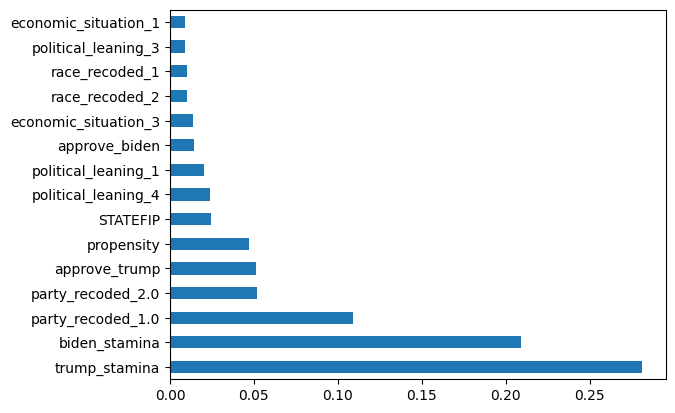

In [127]:
rf = RandomForestClassifier().fit(X_train, y_train)
y_preds_rf = rf.predict(X_test)
print(f1_score(y_test, y_preds_rf, average='weighted'))
print(classification_report(y_test, y_preds_rf))
features=X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

# plt.figure(1)
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), features[indices])
# plt.xlabel('Relative Importance')
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [128]:
new_model.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(learning_rate=0.02, max_features=2, n_estimators=375,
                           random_state=0)>

In [129]:
new_model.fit(X_train, y_train)
y_preds = new_model.predict(X_test)
print(f1_score(y_test, y_preds, average='weighted'))
print(classification_report(y_test, y_preds))

0.9497863106410527
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       247
           1       0.92      0.96      0.94       170

    accuracy                           0.95       417
   macro avg       0.95      0.95      0.95       417
weighted avg       0.95      0.95      0.95       417



In [130]:
y_test.to_numpy()

array([1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,

In [131]:
y_preds

array([1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,

In [132]:
# map preds back up to the original dataframe
nat_2020_clean_copy =nat_2020_clean2.copy()

In [133]:
X_test_copy = X_test.copy()
X_test_copy.columns

Index(['approve_trump', 'approve_biden', 'trump_stamina', 'biden_stamina',
       'optimistic', 'STATEFIP', 'male', 'propensity', 'registered_vote_True',
       'region_1', 'region_2', 'region_3', 'region_4', 'economic_situation_1',
       'economic_situation_2', 'economic_situation_3', 'economic_situation_9',
       'likely_to_vote_1.0', 'likely_to_vote_2.0', 'likely_to_vote_3.0',
       'likely_to_vote_4.0', 'education_recoded_1', 'education_recoded_3',
       'elec_enthusiasm_1.0', 'elec_enthusiasm_2.0', 'elec_enthusiasm_3.0',
       'elec_enthusiasm_9.0', 'political_leaning_1', 'political_leaning_2',
       'political_leaning_3', 'political_leaning_4', 'race_recoded_1',
       'race_recoded_2', 'race_recoded_3', 'race_recoded_4', 'race_recoded_9',
       'party_recoded_1.0', 'party_recoded_2.0', 'party_recoded_3.0',
       'age_recoded_1', 'age_recoded_2', 'age_recoded_3'],
      dtype='object')

In [135]:

X_test_copy['predicted_vote'] = y_preds
X_test_copy['actual_vote'] = y_test
# X_test_copy_filtered = X_test_copy[['approve_trump', 'approve_biden', 'optimistic','focused_imp_issues','male', 'propensity',  'race_recoded_1', 'race_recoded_2', 'race_recoded_3', 'race_recoded_4',
#        'race_recoded_9', 'party_recoded_1.0',
#        'party_recoded_2.0', 'age_recoded_1', 'age_recoded_2', 'age_recoded_3',
#        'vote_choice_recoded', 'actual_vote']]
X_test_copy_filtered = X_test_copy[['approve_trump', 'approve_biden', 'optimistic','male', 'propensity',  'race_recoded_1', 'race_recoded_2', 'race_recoded_3', 'race_recoded_4',
       'race_recoded_9', 'party_recoded_1.0',
       'party_recoded_2.0', 'age_recoded_1', 'age_recoded_2', 'age_recoded_3', 'predicted_vote','actual_vote', 'education_recoded_1', 'education_recoded_3']]

In [136]:
# turn the dummies back into regular columns
X_test_copy_no_dummies = X_test_copy_filtered.copy()


In [137]:
X_test_copy

,approve_trump,approve_biden,trump_stamina,biden_stamina,optimistic,STATEFIP,male,propensity,registered_vote_True,region_1,...,race_recoded_4,race_recoded_9,party_recoded_1.0,party_recoded_2.0,party_recoded_3.0,age_recoded_1,age_recoded_2,age_recoded_3,predicted_vote,actual_vote
354,True,False,True,False,True,47,True,0.648952,True,False,...,False,False,True,False,False,False,True,False,1,1
76,True,False,True,False,True,47,True,0.672078,True,False,...,False,False,True,False,False,True,False,False,1,1
211,True,False,True,False,True,37,False,0.595827,True,False,...,False,False,True,False,False,False,False,True,1,1
434,False,True,False,True,True,6,False,0.034870,True,False,...,False,False,False,True,False,False,True,False,0,0
738,False,False,True,False,False,9,False,0.300055,True,True,...,True,False,True,False,False,False,True,False,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,False,False,False,True,False,13,False,0.172933,True,False,...,False,False,False,True,False,True,False,False,0,0
678,True,False,True,False,True,13,False,0.630585,True,False,...,False,False,True,False,False,False,False,True,1,1
777,False,False,False,True,False,17,False,0.369910,True,False,...,False,False,False,True,False,False,True,False,0,0
823,False,True,False,True,True,17,False,0.039190,True,False,...,False,False,False,True,False,False,True,False,0,0


In [138]:
# filter the nat_2020_june with the indexes in X_test_copy_filtered

filtered_nat_2020_june = nat_2020_june.loc[X_test_copy_filtered.index].drop(columns= ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education', 'state', 'vote_choice_recoded'])
filtered_nat_2020_june['predicted_vote'] = X_test_copy_filtered['predicted_vote']
filtered_nat_2020_june['actual_vote'] = X_test_copy_filtered['actual_vote']
filtered_nat_2020_june

,economic_situation,registered_vote,likely_to_vote,approve_trump,approve_biden,trump_stamina,biden_stamina,optimistic,elec_enthusiasm,political_leaning,...,STATEFIP,party_recoded,age_recoded,race_recoded,male,education_recoded,region,propensity,predicted_vote,actual_vote
354,3,True,1.0,True,False,True,False,True,1.0,4,...,47,1.0,2,1,True,3,3,0.648952,1,1
76,2,True,1.0,True,False,True,False,True,3.0,3,...,47,1.0,1,1,True,1,3,0.672078,1,1
211,2,True,1.0,True,False,True,False,True,1.0,4,...,37,1.0,3,1,False,1,3,0.595827,1,1
434,3,True,1.0,False,True,False,True,True,2.0,3,...,6,2.0,2,2,False,3,4,0.034870,0,0
738,3,True,1.0,False,False,True,False,False,1.0,4,...,9,1.0,2,4,False,3,1,0.300055,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,2,True,1.0,False,False,False,True,False,1.0,1,...,13,2.0,1,3,False,3,3,0.172933,0,0
678,2,True,1.0,True,False,True,False,True,1.0,2,...,13,1.0,3,1,False,1,3,0.630585,1,1
777,2,True,1.0,False,False,False,True,False,1.0,3,...,17,2.0,2,1,False,3,2,0.369910,0,0
823,1,True,1.0,False,True,False,True,True,1.0,3,...,17,2.0,2,2,False,3,2,0.039190,0,0


In [139]:
filtered_nat_2020_june.groupby(['age_recoded','race_recoded',  'male', 'education_recoded'], observed=False)['predicted_vote'].value_counts().unstack(fill_value=0)

predicted_vote                                     0   1
age_recoded race_recoded male  education_recoded        
1           1            False 1                   3   1
                               3                   7   8
                         True  1                   4   9
                               3                  13  10
            2            False 1                   1   0
                               3                   2   0
                         True  1                   1   1
                               3                   3   0
            3            False 1                   0   0
                               3                   2   0
                         True  1                   0   0
                               3                   2   0
            4            False 1                   0   0
                               3                   6   1
                         True  1                   1   1
                               3                   3   1
            9            False 1                   0   0
                               3                   0   0
                         True  1                   0   1
                               3                   0   0
2           1            False 1                   3   5
                               3                  32  22
                         True  1                   0  11
                               3                  21  19
            2            False 1                   1   0
                               3                   9   0
                         True  1                   2   0
                               3                   7   2
            3            False 1                   0   0
                               3                   3   1
                         True  1                   0   0
                               3                   1   1
            4            False 1                   0   0
                               3                   5   5
                         True  1                   0   0
                               3                   5   5
            9            False 1                   0   0
                               3                   2   0
                         True  1                   0   1
                               3                   2   1
3           1            False 1                  10   9
                               3                  32  29
                         True  1                   6   9
                               3                  22  13
            2            False 1                   4   1
                               3                   9   0
                         True  1                   5   0
                               3                   3   0
            3            False 1                   0   0
                               3                   1   1
                         True  1                   0   0
                               3                   0   1
            4            False 1                   1   1
                               3                   1   1
                         True  1                   0   0
                               3                   2   2
            9            False 1                   0   1
                               3                   2   1
                         True  1                   0   0
                               3                   1   2

In [140]:
all_genders = [True, False ]
all_ages = [1,2, 3]
all_educations = [1,3]
all_races = [1,2, 3,4,9]
all_combinations = pd.MultiIndex.from_product([all_ages,all_races, all_genders, all_educations], names=['age_recoded','race_recoded', 'male','education_recoded']).to_frame(index=False)
pd.merge(all_combinations, filtered_nat_2020_june.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0), on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')


/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_15388/3494734789.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd.merge(all_combinations, filtered_nat_2020_june.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0), on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')


,age_recoded,race_recoded,male,education_recoded,0,1
0,1,1,False,1,3,1
1,1,1,False,3,7,8
2,1,1,True,1,4,9
3,1,1,True,3,13,10
4,1,2,False,1,1,0
5,1,2,False,3,2,0
6,1,2,True,1,1,1
7,1,2,True,3,3,0
8,1,3,False,1,0,0
9,1,3,False,3,2,0


In [141]:
june_final = filtered_nat_2020_june.groupby(['age_recoded','race_recoded', 'male','education_recoded'], observed=False)['predicted_vote'].value_counts().unstack(fill_value=0)
filtered_nat_2020_june.groupby(['age_recoded','race_recoded', 'male','education_recoded'], observed=True)['predicted_vote'].value_counts().unstack(fill_value=0)

predicted_vote                                     0   1
age_recoded race_recoded male  education_recoded        
1           1            False 1                   3   1
                               3                   7   8
                         True  1                   4   9
                               3                  13  10
            2            False 1                   1   0
                               3                   2   0
                         True  1                   1   1
                               3                   3   0
            3            False 3                   2   0
                         True  3                   2   0
            4            False 3                   6   1
                         True  1                   1   1
                               3                   3   1
            9            True  1                   0   1
2           1            False 1                   3   5
                               3                  32  22
                         True  1                   0  11
                               3                  21  19
            2            False 1                   1   0
                               3                   9   0
                         True  1                   2   0
                               3                   7   2
            3            False 3                   3   1
                         True  3                   1   1
            4            False 3                   5   5
                         True  3                   5   5
            9            False 3                   2   0
                         True  1                   0   1
                               3                   2   1
3           1            False 1                  10   9
                               3                  32  29
                         True  1                   6   9
                               3                  22  13
            2            False 1                   4   1
                               3                   9   0
                         True  1                   5   0
                               3                   3   0
            3            False 3                   1   1
                         True  3                   0   1
            4            False 1                   1   1
                               3                   1   1
                         True  3                   2   2
            9            False 1                   0   1
                               3                   2   1
                         True  3                   1   2

In [144]:

filtered_nat_2020 = nat_2020_pre_dummies.loc[X_test_copy_filtered.index].drop(columns= ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education', 'state', 'vote_choice_recoded'])
filtered_nat_2020['predicted_vote'] = X_test_copy_filtered['predicted_vote']
filtered_nat_2020['actual_vote'] = X_test_copy_filtered['actual_vote']
filtered_nat_2020
march_final = filtered_nat_2020.groupby(['age_recoded','race_recoded', 'male','education_recoded'], observed=False)['predicted_vote'].value_counts().unstack(fill_value=0)
filtered_nat_2020.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0)
# merge with just the

KeyError: '[76, 738, 152, 626, 864, 36, 646, 863, 173, 679, 392, 34, 209, 866, 457, 856, 115, 807, 141, 381, 186, 377, 125, 148, 857, 862, 698, 216, 261, 82, 567, 688, 221, 168, 371, 382, 136, 228, 745, 126, 705, 383, 332, 859, 43, 395, 847, 860, 122, 172, 731, 225, 525, 372] not in index'

In [145]:
merged_df = pd.merge(march_final, june_final, on=['age_recoded',	'race_recoded',	'male',	'education_recoded'], how='outer').fillna(0)
merged_df

NameError: name 'march_final' is not defined

In [344]:
# filtered_nat_2020 and filtered_nat_2020_june merge on the same columns
filtered_nat_2020_june.columns
merged_df = pd.merge(march_final, june_final, on=['age_recoded',	'race_recoded',	'male',	'education_recoded'], how='outer').fillna(0)
# add 0_x and 0_y together
merged_df['0'] = merged_df['0_x'] + merged_df['0_y']
# add 1_x and 1_y together
merged_df['1'] = merged_df['1_x'] + merged_df['1_y']
# drop the _x and _y columns
merged_df = merged_df.drop(columns = ['0_x', '0_y', '1_x', '1_y'])
merged_df
# add the propensity vibe column
merged_df['propensity_t_pred'] = merged_df['1'] / (merged_df['0'] + merged_df['1'])
merged_df

NameError: name 'march_final' is not defined

In [ ]:
# TODO: make function/pipeline that can take in multiple custom datasets to build bigger propensity changer. Then you could use that to continue to cook with new stuff? do more monmouth? maybe 2 more of those plus whatever else we have?

# TODO: Aggregate the propensities from ML and MRP and see if they're similar ish. Then use that to make a new propensity score.

# TODO: with updated propensity score and Census People data from haley, ("../data/census/cleaned/post_stratification_data.csv") multiply by the amount of people in each category and then see if it's predicting the election right on a high level. See if You can find a way to weight the ML scores down to not make it change much. See if certain groups don't show as much. -> use turnout weights to bonk the numbers down to be more realistic?

# TODO: simulate running the ML a bunch of times to get more predictions? like oversample??? OOOOH SMOte LOL

# TODO: include people we dropped for 3rd party purposes? no validation fs but will bump average numbers based on how model predicts

In [345]:
# propensity = pd.read_csv("../data/output7.csv")
propensity = pd.read_csv("../data/output11.csv")
post_strat = pd.read_csv("../data/post_stratification_data.csv")
post_strat = post_strat.drop(columns = ['prop'])
# propensity = propensity.drop(columns = ['mrp_subgroup_estimate_se'])
propensity_strat = pd.merge(propensity, post_strat)
propensity_strat
merged_df = merge_mar_june.copy()

In [346]:
merged_df

,age_recoded,race_recoded,male,education_recoded,0,1,propensity_t_pred
0,1,1,False,1,4.0,1.0,0.200000
1,1,1,False,3,15.0,12.0,0.444444
2,1,1,True,1,6.0,9.0,0.600000
3,1,1,True,3,35.0,13.0,0.270833
4,1,2,False,1,1.0,0.0,0.000000
5,1,2,False,3,2.0,0.0,0.000000
6,1,2,True,1,1.0,1.0,0.500000
7,1,2,True,3,5.0,0.0,0.000000
8,1,3,False,1,0.0,0.0,NaN
9,1,3,False,3,4.0,0.0,0.000000


In [347]:
propensity

,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate,mrp_subgroup_estimate_se
0,1,1,False,1,1,0.679457,0.080854
1,1,1,False,1,2,0.732036,0.082192
2,1,1,False,1,4,0.579128,0.077876
3,1,1,False,1,5,0.620041,0.121134
4,1,1,False,1,6,0.388438,0.072786
...,...,...,...,...,...,...,...
2935,3,9,True,3,51,0.600421,0.116523
2936,3,9,True,3,53,0.498659,0.119723
2937,3,9,True,3,54,0.631852,0.113445
2938,3,9,True,3,55,0.587575,0.114131


In [348]:
post_strat = pd.read_csv("../data/post_stratification_data_by_state.csv")
propensity = pd.read_csv("../data/output11.csv")
megaStrat = pd.merge(propensity, post_strat, how='left', on=['STATEFIP',	'age_recoded',	'race_recoded'	,'male'	,'education_recoded'])
megaStrat = megaStrat.dropna()

In [349]:
# propensity = pd.read_csv("../data/output7.csv") 
propensity = pd.read_csv("../data/output11.csv")
# 7 is best so far
# propensity = pd.read_csv("../data/output10.csv")
# post_strat = pd.read_csv("../data/post_stratification_data.csv")
# post_strat = pd.read_csv("../data/post_stratification_data_by_state.csv")

# post_strat = post_strat.drop(columns = ['prop'])
# # propensity = propensity.drop(columns = ['mrp_subgroup_estimate_se'])
# propensity_strat = pd.merge(propensity, post_strat)
# multiply by 0.595 if male, 0.63 if female
propensity_strat = megaStrat.copy()

propensity_strat['PERWT_scaled'] = propensity_strat.apply(
    lambda row: row['PERWT'] * 0.595 if row['male'] else row['PERWT'] * 0.63, axis=1
)



multipliers_age = {
    1: 0.55,
    2: 0.656,
    3: 0.73,
}
# White 69.8, black 58.7, asian 42.8, latino 38.8
# 2018 57.5, 51.4, 40.4, 40.3

multipliers = {
    1: 0.575,
    2: 0.514,
    3: 0.404,
    4: 0.403,
    9: 0.5
}

# make perwt scaled multiplied if its white black asian or latino
propensity_strat['PERWT_scaled_race'] = propensity_strat.apply(lambda row: row['PERWT'] * multipliers[row['race_recoded']], axis=1)

propensity_strat['PERWT_scaled_age'] = propensity_strat.apply(lambda row: row['PERWT'] * multipliers_age[row['age_recoded']], axis=1)

# propensity_strat['PERWT_scaled'] = propensity_strat.apply(
# propensity_strat['PERWT_scaled'] = propensity_strat.apply(
#     lambda row: row['PERWT'] * 0.698 if row['race_recoded'] == 1 elif row['PERWT'] * 0.698 if row['race_recoded'] == 1 else row['PERWT'] * 0.63, axis=1
# )
propensity_strat['trumpVote'] = propensity_strat['mrp_subgroup_estimate'] * propensity_strat['PERWT_scaled']
propensity_strat['bidenVote'] = (1 - propensity_strat['mrp_subgroup_estimate']) * propensity_strat['PERWT_scaled']
propensity_strat
print('trump percent', propensity_strat['trumpVote'].sum() / (propensity_strat['trumpVote'].sum() + propensity_strat['bidenVote'].sum()), 'trumpSum', propensity_strat['trumpVote'].sum())
print('biden percent', propensity_strat['bidenVote'].sum() / (propensity_strat['trumpVote'].sum() + propensity_strat['bidenVote'].sum()), 'bidenSum', propensity_strat['bidenVote'].sum())
propensity_strat

trump percent 0.4910874839836854 trumpSum 75401820.23110397
biden percent 0.5089125160163146 bidenSum 78138684.64889602


,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate,mrp_subgroup_estimate_se,PERWT,prop,PERWT_scaled,PERWT_scaled_race,PERWT_scaled_age,trumpVote,bidenVote
0,1,1,False,1,1,0.679457,0.080854,327170.0,1.291648e-03,206117.100,188122.750,179943.50,140047.661156,66069.438844
1,1,1,False,1,2,0.732036,0.082192,47024.0,1.856480e-04,29625.120,27038.800,25863.20,21686.663943,7938.456057
2,1,1,False,1,4,0.579128,0.077876,358383.0,1.414875e-03,225781.290,206070.225,197110.65,130756.371494,95024.918506
3,1,1,False,1,5,0.620041,0.121134,221846.0,8.758351e-04,139762.980,127561.450,122015.30,86658.734910,53104.245090
4,1,1,False,1,6,0.388438,0.072786,1424354.0,5.623267e-03,897343.020,819003.550,783394.70,348562.253953,548780.766047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934,3,9,True,3,50,0.433989,0.118686,11.0,4.342736e-08,6.545,5.500,8.03,2.840457,3.704543
2935,3,9,True,3,51,0.600421,0.116523,556.0,2.195056e-06,330.820,278.000,405.88,198.631124,132.188876
2936,3,9,True,3,53,0.498659,0.119723,342.0,1.350196e-06,203.490,171.000,249.66,101.472189,102.017811
2937,3,9,True,3,54,0.631852,0.113445,77.0,3.039915e-07,45.815,38.500,56.21,28.948309,16.866691


In [350]:
pd.merge(propensity_strat, merged_df, on = ['age_recoded', 'education_recoded','male', 'race_recoded'], how='left')

,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate,mrp_subgroup_estimate_se,PERWT,prop,PERWT_scaled,PERWT_scaled_race,PERWT_scaled_age,trumpVote,bidenVote,0,1,propensity_t_pred
0,1,1,False,1,1,0.679457,0.080854,327170.0,1.291648e-03,206117.100,188122.750,179943.50,140047.661156,66069.438844,4.0,1.0,0.2
1,1,1,False,1,2,0.732036,0.082192,47024.0,1.856480e-04,29625.120,27038.800,25863.20,21686.663943,7938.456057,4.0,1.0,0.2
2,1,1,False,1,4,0.579128,0.077876,358383.0,1.414875e-03,225781.290,206070.225,197110.65,130756.371494,95024.918506,4.0,1.0,0.2
3,1,1,False,1,5,0.620041,0.121134,221846.0,8.758351e-04,139762.980,127561.450,122015.30,86658.734910,53104.245090,4.0,1.0,0.2
4,1,1,False,1,6,0.388438,0.072786,1424354.0,5.623267e-03,897343.020,819003.550,783394.70,348562.253953,548780.766047,4.0,1.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873,3,9,True,3,50,0.433989,0.118686,11.0,4.342736e-08,6.545,5.500,8.03,2.840457,3.704543,0.0,2.0,1.0
2874,3,9,True,3,51,0.600421,0.116523,556.0,2.195056e-06,330.820,278.000,405.88,198.631124,132.188876,0.0,2.0,1.0
2875,3,9,True,3,53,0.498659,0.119723,342.0,1.350196e-06,203.490,171.000,249.66,101.472189,102.017811,0.0,2.0,1.0
2876,3,9,True,3,54,0.631852,0.113445,77.0,3.039915e-07,45.815,38.500,56.21,28.948309,16.866691,0.0,2.0,1.0


In [351]:
merged_df['propensity_t_pred'].values

array([0.2       , 0.44444444, 0.6       , 0.27083333, 0.        ,
       0.        , 0.5       , 0.        ,        nan, 0.        ,
              nan, 0.        , 0.        , 0.25      , 0.75      ,
       0.44444444, 0.        ,        nan, 1.        , 0.5       ,
       0.81818182, 0.475     , 0.86666667, 0.484375  , 0.        ,
       0.        , 0.        , 0.15384615,        nan, 0.33333333,
              nan, 0.25      ,        nan, 0.5       , 1.        ,
       0.46153846,        nan, 0.        , 1.        , 0.5       ,
       0.51612903, 0.56666667, 0.6875    , 0.46153846, 0.        ,
       0.        , 0.        , 0.        ,        nan, 0.25      ,
              nan, 0.        , 0.        , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.33333333,        nan, 1.        ])

In [352]:
# propensity_strat['ML_pred'] = pd.merge(merged_df['propensity_t_pred'].values)
# fill with the originall propensity score if 0
propensity_strat = pd.merge(propensity_strat, merged_df, on = ['age_recoded', 'education_recoded','male', 'race_recoded'], how='left')
propensity_strat['ML_pred'] = propensity_strat['propensity_t_pred']

propensity_strat['ML_pred'] = propensity_strat['ML_pred'].fillna(propensity_strat['mrp_subgroup_estimate'])

In [353]:
propensity_strat

,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate,mrp_subgroup_estimate_se,PERWT,prop,PERWT_scaled,PERWT_scaled_race,PERWT_scaled_age,trumpVote,bidenVote,0,1,propensity_t_pred,ML_pred
0,1,1,False,1,1,0.679457,0.080854,327170.0,1.291648e-03,206117.100,188122.750,179943.50,140047.661156,66069.438844,4.0,1.0,0.2,0.2
1,1,1,False,1,2,0.732036,0.082192,47024.0,1.856480e-04,29625.120,27038.800,25863.20,21686.663943,7938.456057,4.0,1.0,0.2,0.2
2,1,1,False,1,4,0.579128,0.077876,358383.0,1.414875e-03,225781.290,206070.225,197110.65,130756.371494,95024.918506,4.0,1.0,0.2,0.2
3,1,1,False,1,5,0.620041,0.121134,221846.0,8.758351e-04,139762.980,127561.450,122015.30,86658.734910,53104.245090,4.0,1.0,0.2,0.2
4,1,1,False,1,6,0.388438,0.072786,1424354.0,5.623267e-03,897343.020,819003.550,783394.70,348562.253953,548780.766047,4.0,1.0,0.2,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873,3,9,True,3,50,0.433989,0.118686,11.0,4.342736e-08,6.545,5.500,8.03,2.840457,3.704543,0.0,2.0,1.0,1.0
2874,3,9,True,3,51,0.600421,0.116523,556.0,2.195056e-06,330.820,278.000,405.88,198.631124,132.188876,0.0,2.0,1.0,1.0
2875,3,9,True,3,53,0.498659,0.119723,342.0,1.350196e-06,203.490,171.000,249.66,101.472189,102.017811,0.0,2.0,1.0,1.0
2876,3,9,True,3,54,0.631852,0.113445,77.0,3.039915e-07,45.815,38.500,56.21,28.948309,16.866691,0.0,2.0,1.0,1.0


In [354]:
propensity_strat['newcol'] = propensity_strat.apply(
    lambda row: row['ML_pred'] if row['ML_pred'] != 0 else row['mrp_subgroup_estimate'] / 2, axis=1
)

# .apply(lambda s: s if s != 0 else propensity_strat['mrp_subgroup_estimate'] / 2)


In [355]:
# propensity_strat['ML_pred'] = merged_df['propensity_t_pred'].values
# fill with the originall propensity score if 0
propensity_strat['ML_pred'] = propensity_strat['ML_pred'].fillna(propensity_strat['mrp_subgroup_estimate'])
# if ML pred is 0, fill with MRP pred / 2

propensity_strat.loc[propensity_strat['ML_pred'] == 0, 'ML_pred'] = propensity_strat['mrp_subgroup_estimate'] / 8
propensity_strat.loc[propensity_strat['ML_pred'] == 1, 'ML_pred'] = 1 - (propensity_strat['mrp_subgroup_estimate'] / 2 )

#weight the mrp and ml predictions by the PERWT_scaled
propensity_strat['mrp_and_ML'] = ((propensity_strat['mrp_subgroup_estimate'] * 2) + propensity_strat['ML_pred']) / 3
propensity_strat
propensity_strat['trumpVote_altered'] = propensity_strat['mrp_and_ML'] * propensity_strat['PERWT_scaled']
propensity_strat['bidenVote_altered'] = (1 - propensity_strat['mrp_and_ML']) * propensity_strat['PERWT_scaled']
print('trump sum', propensity_strat['trumpVote_altered'].sum(), 'biden sum', propensity_strat['bidenVote_altered'].sum())
print('trump percent', propensity_strat['trumpVote_altered'].sum() / (propensity_strat['trumpVote_altered'].sum() + propensity_strat['bidenVote_altered'].sum()))
print('biden percent', propensity_strat['bidenVote_altered'].sum() / (propensity_strat['trumpVote_altered'].sum() + propensity_strat['bidenVote_altered'].sum()))

trump sum 76219605.3122079 biden sum 77320899.56779207
trump percent 0.49641366863927894
biden percent 0.503586331360721


In [356]:
propensity_strat

,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate,mrp_subgroup_estimate_se,PERWT,prop,PERWT_scaled,...,trumpVote,bidenVote,0,1,propensity_t_pred,ML_pred,newcol,mrp_and_ML,trumpVote_altered,bidenVote_altered
0,1,1,False,1,1,0.679457,0.080854,327170.0,1.291648e-03,206117.100,...,140047.661156,66069.438844,4.0,1.0,0.2,0.200000,0.2,0.519638,107106.247437,99010.852563
1,1,1,False,1,2,0.732036,0.082192,47024.0,1.856480e-04,29625.120,...,21686.663943,7938.456057,4.0,1.0,0.2,0.200000,0.2,0.554691,16432.783962,13192.336038
2,1,1,False,1,4,0.579128,0.077876,358383.0,1.414875e-03,225781.290,...,130756.371494,95024.918506,4.0,1.0,0.2,0.200000,0.2,0.452752,102223.000329,123558.289671
3,1,1,False,1,5,0.620041,0.121134,221846.0,8.758351e-04,139762.980,...,86658.734910,53104.245090,4.0,1.0,0.2,0.200000,0.2,0.480027,67090.021940,72672.958060
4,1,1,False,1,6,0.388438,0.072786,1424354.0,5.623267e-03,897343.020,...,348562.253953,548780.766047,4.0,1.0,0.2,0.200000,0.2,0.325625,292197.703969,605145.316031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873,3,9,True,3,50,0.433989,0.118686,11.0,4.342736e-08,6.545,...,2.840457,3.704543,0.0,2.0,1.0,0.783006,1.0,0.550328,3.601895,2.943105
2874,3,9,True,3,51,0.600421,0.116523,556.0,2.195056e-06,330.820,...,198.631124,132.188876,0.0,2.0,1.0,0.699790,1.0,0.633544,209.588895,121.231105
2875,3,9,True,3,53,0.498659,0.119723,342.0,1.350196e-06,203.490,...,101.472189,102.017811,0.0,2.0,1.0,0.750670,1.0,0.582663,118.566094,84.923906
2876,3,9,True,3,54,0.631852,0.113445,77.0,3.039915e-07,45.815,...,28.948309,16.866691,0.0,2.0,1.0,0.684074,1.0,0.649259,29.745821,16.069179


In [357]:
propensity_strat_breakdown = propensity_strat[['male', 'age_recoded','race_recoded', 'education_recoded', 'mrp_subgroup_estimate', 'ML_pred', 'mrp_and_ML', 'STATEFIP']]

In [373]:
census_by_state = pd.read_csv("../data/post_stratification_data_by_state.csv")
census_by_state
elec_votes2 = pd.read_csv("../data/2020_electoral_results.csv")
elec_votes = pd.read_csv("../data/2020_ecollege_rep.csv")
elec_votes
# merge the two on stateFIP
census_by_state = pd.merge(census_by_state, elec_votes, left_on = 'STATEFIP', right_on = 'STATEFP')
census_by_state = pd.merge(census_by_state, elec_votes2, left_on = 'state', right_on = 'State')
# White 69.8, black 58.7, asian 42.8, latino 38.8

# multipliers = {
#     1: 0.698,
#     2: 0.587,
#     3: 0.428,
#     4: 0.388,
#     9: 1
# }

# # make perwt scaled multiplied if its white black asian or latino
# census_by_state['PERWT_scaled'] = census_by_state.apply(lambda row: row['PERWT'] * multipliers[row['race_recoded']], axis=1)
census_by_state['PERWT_scaled'] = census_by_state.apply(
    lambda row: row['PERWT'] * 0.595 if row['male'] else row['PERWT'] * 0.63, axis=1
)
# map the propensity strat to the census data by education, age, race, gender
census_by_state = pd.merge(census_by_state, propensity_strat_breakdown, on = ['age_recoded', 'education_recoded','male', 'race_recoded', 'STATEFIP' ])
# # census_by_state['mrp_and_ML'] = propensity_strat['mrp_and_ML']
# census_by_state
census_by_state

,STATEFIP,age_recoded,race_recoded,male,education_recoded,PERWT,prop,STATE,STATEFP,STATENS,...,State,state_votes,biden,trump,harris,pence,PERWT_scaled,mrp_subgroup_estimate,ML_pred,mrp_and_ML
0,1,1,1,False,1,327170.0,1.291648e-03,AL,1,1779775,...,alabama,9,0,9,0,9,206117.100,0.679457,0.200000,0.519638
1,1,1,1,False,3,1916.0,7.564257e-06,AL,1,1779775,...,alabama,9,0,9,0,9,1207.080,0.566171,0.444444,0.525595
2,1,1,1,True,1,330345.0,1.304183e-03,AL,1,1779775,...,alabama,9,0,9,0,9,196555.275,0.748718,0.600000,0.699145
3,1,1,1,True,3,2014.0,7.951155e-06,AL,1,1779775,...,alabama,9,0,9,0,9,1198.330,0.646978,0.270833,0.521597
4,1,1,2,False,1,171855.0,6.784736e-04,AL,1,1779775,...,alabama,9,0,9,0,9,108268.650,0.219972,0.027496,0.155813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873,56,3,4,True,1,4098.0,1.617867e-05,WY,56,1779807,...,wyoming,3,0,3,0,3,2438.310,0.777065,0.500000,0.684710
2874,56,3,4,True,3,197.0,7.777446e-07,WY,56,1779807,...,wyoming,3,0,3,0,3,117.215,0.684754,0.500000,0.623170
2875,56,3,9,False,1,2080.0,8.211719e-06,WY,56,1779807,...,wyoming,3,0,3,0,3,1310.400,0.811494,0.500000,0.707663
2876,56,3,9,False,3,48.0,1.895012e-07,WY,56,1779807,...,wyoming,3,0,3,0,3,30.240,0.729696,0.333333,0.597575


In [374]:
turnout_state = pd.read_csv("../data/turnout_by_state.csv")
turnout_state['STATE_NAME'] = turnout_state['State'].str.lower()
census_by_state2 = pd.merge(census_by_state, turnout_state, on = ['STATE_NAME'])
census_by_state2['PERWT_state_scaled'] = census_by_state2['PERWT_scaled'] / 100 * census_by_state2['2020_turnout']
# census_by_state['PERWT_scaled'] = census_by_state.apply(
#     lambda row: row['PERWT'] * row['2020_turnout'] if row['male'] else row['PERWT'] * 0.63, axis=1
# )
# census_by_state2.loc[census_by_state2['state'] == 'massachusetts']


In [375]:
# census_by_state = pd.read_csv("../data/post_stratification_data_by_state.csv")
# census_by_state = pd.merge(census_by_state, propensity_strat_breakdown, on = ['age_recoded', 'education_recoded','male', 'race_recoded'])
# census_by_state = pd.merge(census_by_state, elec_votes, left_on = 'STATEFIP', right_on = 'STATEFP')
# census_by_state

In [376]:
allStates

,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate,mrp_subgroup_estimate_se_x,mrp_subgroup_estimate_x,mrp_subgroup_estimate_se_y,PERWT,...,mrp_and_ML,State_y,2020_turnout_x,PERWT_state_scaled,bothScores,trump_votes_states,biden_votes_states,state_demo_ratio,State,2020_turnout_y
0,1,1,False,1,1,0.679457,0.080854,0.558285,0.057187,327170.0,...,0.519638,Alabama,60.5,197937.850,0.558285,115072.008540,91045.091460,0.558285,Alabama,60.5
1,1,1,False,1,2,0.732036,0.082192,0.610915,0.060845,47024.0,...,0.554691,Alaska,63.8,30001.312,0.610915,18098.425246,11526.694754,0.610915,Alaska,63.8
2,1,1,False,1,4,0.579128,0.077876,0.538763,0.050655,358383.0,...,0.452752,Arizona,71.9,257677.377,0.538763,121642.557207,104138.732793,0.538763,Arizona,71.9
3,1,1,False,1,5,0.620041,0.121134,0.643823,0.070566,221846.0,...,0.480027,Arkansas,54.0,119796.840,0.643823,89982.558983,49780.421017,0.643823,Arkansas,54.0
4,1,1,False,1,6,0.388438,0.072786,0.367183,0.045495,1424354.0,...,0.325625,California,65.1,927254.454,0.367183,329489.230020,567853.789980,0.367183,California,65.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873,3,9,True,3,50,0.433989,0.118686,0.383861,0.068195,11.0,...,0.550328,Vermont,68.4,7.524,0.383861,2.512370,4.032630,0.383861,Vermont,68.4
2874,3,9,True,3,51,0.600421,0.116523,0.563470,0.076625,556.0,...,0.633544,Virginia,71.5,397.540,0.563470,186.406981,144.413019,0.563470,Virginia,71.5
2875,3,9,True,3,53,0.498659,0.119723,0.444764,0.071476,342.0,...,0.582663,Washington,71.5,244.530,0.444764,90.505071,112.984929,0.444764,Washington,71.5
2876,3,9,True,3,54,0.631852,0.113445,0.579630,0.070781,77.0,...,0.649259,West Virginia,56.1,43.197,0.579630,26.555742,19.259258,0.579630,West Virginia,56.1


In [377]:
allStates = pd.read_csv("../data/output11.csv")

elec_votes = pd.read_csv("../data/2020_electoral_results.csv")
elec_votes
# merge the two on stateFIP
allStates = pd.merge(allStates, census_by_state,  on = ['age_recoded', 'education_recoded','male', 'race_recoded', 'STATEFIP'])
# allStates = pd.merge(allStates, elec_votes, left_on = 'STATEFIP', right_on = 'STATEFP')
# census_by_state = pd.merge(census_by_state, elec_votes, left_on = 'STATEFIP', right_on = 'STATEFP')
turnout_state = pd.read_csv("../data/turnout_by_state.csv")
turnout_state['STATE_NAME'] = turnout_state['State'].str.lower()
# allStates['mrp_subgroup_estimate_x'].fillna(allStates['mrp_subgroup_estimate_y'], inplace = True)
# allStates['PERWT_scaled'] = allStates.apply(
#     lambda row: row['PERWT'] * 0.595 if row['male'] else row['PERWT'] * 0.63, axis=1
# )
allStates = pd.merge(allStates, turnout_state, on = ['STATE_NAME'])
allStates['PERWT_state_scaled'] = allStates['PERWT'] / 100 * allStates['2020_turnout']
allStates['PERWT_scaled'] = allStates.apply(
    lambda row: row['PERWT'] * 0.595 if row['male'] else row['PERWT'] * 0.63, axis=1
)
allStates

,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate_x,mrp_subgroup_estimate_se,PERWT,prop,STATE,...,trump,harris,pence,PERWT_scaled,mrp_subgroup_estimate_y,ML_pred,mrp_and_ML,State_y,2020_turnout,PERWT_state_scaled
0,1,1,False,1,1,0.679457,0.080854,327170.0,1.291648e-03,AL,...,9,0,9,206117.100,0.679457,0.200000,0.519638,Alabama,60.5,197937.850
1,1,1,False,1,2,0.732036,0.082192,47024.0,1.856480e-04,AK,...,3,0,3,29625.120,0.732036,0.200000,0.554691,Alaska,63.8,30001.312
2,1,1,False,1,4,0.579128,0.077876,358383.0,1.414875e-03,AZ,...,0,11,0,225781.290,0.579128,0.200000,0.452752,Arizona,71.9,257677.377
3,1,1,False,1,5,0.620041,0.121134,221846.0,8.758351e-04,AR,...,6,0,6,139762.980,0.620041,0.200000,0.480027,Arkansas,54.0,119796.840
4,1,1,False,1,6,0.388438,0.072786,1424354.0,5.623267e-03,CA,...,0,55,0,897343.020,0.388438,0.200000,0.325625,California,65.1,927254.454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873,3,9,True,3,50,0.433989,0.118686,11.0,4.342736e-08,VT,...,0,3,0,6.545,0.433989,0.783006,0.550328,Vermont,68.4,7.524
2874,3,9,True,3,51,0.600421,0.116523,556.0,2.195056e-06,VA,...,0,13,0,330.820,0.600421,0.699790,0.633544,Virginia,71.5,397.540
2875,3,9,True,3,53,0.498659,0.119723,342.0,1.350196e-06,WA,...,0,12,0,203.490,0.498659,0.750670,0.582663,Washington,71.5,244.530
2876,3,9,True,3,54,0.631852,0.113445,77.0,3.039915e-07,WV,...,5,0,5,45.815,0.631852,0.684074,0.649259,West Virginia,56.1,43.197


# With ML

In [378]:
# group by states and then predict if the state will go red or blue
census_by_state = allStates.copy()
# census_by_state['bothScores'] = census_by_state['mrp_subgroup_estimate_x'] 
census_by_state['bothScores'] = ((census_by_state['mrp_subgroup_estimate_x'] * 5 ) + census_by_state['ML_pred']) / 6

census_by_state['trump_votes_states'] = census_by_state['bothScores'] * census_by_state['PERWT_scaled']
census_by_state['biden_votes_states'] = (1 - census_by_state['bothScores']) * census_by_state['PERWT_scaled']
# sum up total trump/biden votes 

census_by_state['state_demo_ratio'] =  census_by_state['trump_votes_states'] / (census_by_state['trump_votes_states'] + census_by_state['biden_votes_states'] )
# census_by_state['mrp_and_ML'].value_counts()
elec_college_pred = census_by_state.groupby('state')[['trump_votes_states','biden_votes_states'] ].sum()
# if trump votes > biden votes, then trump wins the state
elec_college_pred['state_pred'] = elec_college_pred.apply(lambda row: 1 if row['trump_votes_states'] > row['biden_votes_states'] else 0, axis = 1)
elec_college_pred
final_pred = pd.merge(elec_college_pred, elec_votes[:51], left_on = 'state', right_on = 'State')
final_pred
print('trump sum', final_pred['trump_votes_states'].sum(), 'biden sum', final_pred['biden_votes_states'].sum())
final_pred['state_votes'] = final_pred['state_votes'].astype(int)
# sum up electoral votes for all states with pred of 1 and 0
final_pred.groupby('state_pred')['state_votes'].sum()

trump sum 75810712.77165595 biden sum 77729792.10834405


state_pred
0    262
1    267
Name: state_votes, dtype: int64

In [379]:
final_pred

,trump_votes_states,biden_votes_states,state_pred,State,state_votes,biden,trump,harris,pence
0,1.344959e+06,9.860168e+05,1,alabama,9,0,9,0,9
1,2.435568e+05,9.493951e+04,1,alaska,3,0,3,0,3
2,1.955520e+06,1.435650e+06,1,arizona,11,11,0,11,0
3,8.245998e+05,5.909595e+05,1,arkansas,6,0,6,0,6
4,7.137328e+06,1.148620e+07,0,california,55,55,0,55,0
5,1.481747e+06,1.229424e+06,1,colorado,9,9,0,9,0
6,7.264846e+05,1.011964e+06,0,connecticut,7,7,0,7,0
7,2.124628e+05,2.556139e+05,0,delaware,3,3,0,3,0
8,6.170119e+04,2.917954e+05,0,district of columbia,3,3,0,3,0
9,5.415038e+06,5.008941e+06,1,florida,29,0,29,0,29


# no ML

In [380]:
# group by states and then predict if the state will go red or blue
census_by_state = allStates.copy()
census_by_state['bothScores'] = census_by_state['mrp_subgroup_estimate_x'] 
# census_by_state['bothScores'] = ((census_by_state['mrp_subgroup_estimate_x'] *2 ) + census_by_state['ML_pred']) / 3

census_by_state['trump_votes_states'] = census_by_state['bothScores'] * census_by_state['PERWT_scaled']
census_by_state['biden_votes_states'] = (1 - census_by_state['bothScores']) * census_by_state['PERWT_scaled']
# sum up total trump/biden votes 

census_by_state['state_demo_ratio'] =  census_by_state['trump_votes_states'] / (census_by_state['trump_votes_states'] + census_by_state['biden_votes_states'] )
# census_by_state['mrp_and_ML'].value_counts()
elec_college_pred = census_by_state.groupby('state')[['trump_votes_states','biden_votes_states'] ].sum()
# if trump votes > biden votes, then trump wins the state
elec_college_pred['state_pred'] = elec_college_pred.apply(lambda row: 1 if row['trump_votes_states'] > row['biden_votes_states'] else 0, axis = 1)
elec_college_pred
final_pred = pd.merge(elec_college_pred, elec_votes2, left_on = 'state', right_on = 'State')
# final_pred = elec_college_pred
print('trump sum', final_pred['trump_votes_states'].sum(), 'biden sum', final_pred['biden_votes_states'].sum())
final_pred['state_votes'] = final_pred['state_votes'].astype(int)
# sum up electoral votes for all states with pred of 1 and 0
final_pred.groupby('state_pred')['state_votes'].sum()

trump sum 75401820.23110399 biden sum 78138684.64889602


state_pred
0    262
1    267
Name: state_votes, dtype: int64

In [381]:
final_pred.groupby('state_pred')['state_votes'].sum()

state_pred
0    262
1    267
Name: state_votes, dtype: int64

In [382]:
cState = pd.read_csv("../data/post_stratification_data_by_state.csv")
census_by_state
elec_votes = pd.read_csv("../data/2020_ecollege_rep.csv")
elec_votes
# merge the two on stateFIP
cState = pd.merge(cState, elec_votes, left_on = 'STATEFIP', right_on = 'STATEFP')
cState.columns
cState.drop(columns=[ 'prop','STATENS', 'STATE_NAME','STATE' ], inplace=True)

In [383]:
cState

,STATEFIP,age_recoded,race_recoded,male,education_recoded,PERWT,STATEFP,state,e_votes
0,1,1,1,False,1,327170.0,1,alabama,9.0
1,1,1,1,False,3,1916.0,1,alabama,9.0
2,1,1,1,True,1,330345.0,1,alabama,9.0
3,1,1,1,True,3,2014.0,1,alabama,9.0
4,1,1,2,False,1,171855.0,1,alabama,9.0
...,...,...,...,...,...,...,...,...,...
2990,56,3,4,True,1,4098.0,56,wyoming,3.0
2991,56,3,4,True,3,197.0,56,wyoming,3.0
2992,56,3,9,False,1,2080.0,56,wyoming,3.0
2993,56,3,9,False,3,48.0,56,wyoming,3.0
